In [1]:
import matplotlib.pylab as plt
import numpy as np
from astropy import units as u
from astropy.io import fits
import aplpy
import matplotlib.patheffects as pe
from astropy.wcs import WCS

import cmocean

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def figure_layout( fig, c_unit, fontcolor='white', colorbar=True, recenter=True, boxsize=0.008):
    fig.set_nan_color('0.95')
    
    # beam 
    fig.add_beam()
    fig.beam.set(facecolor='white', edgecolor='black', hatch='////////')
    
    # 
    fig.axis_labels.set_font(size=15)
    fig.axis_labels.set_xtext('Right Ascension (ICRS)')
    fig.axis_labels.set_ytext('Declination (ICRS)')
    fig.axis_labels.set_ypad(pad=-1.5)
    #fig.tick_labels.set_yformat('d.ddd')
    #fig.tick_labels.set_xformat('d.ddd')

    ## Scale bar
    ang_sep = (14*u.arcsec).to(u.rad)
    fig.add_scalebar(ang_sep)
    fig.scalebar.set_label("$14''$")
    fig.scalebar.set_font(size=22)
    fig.scalebar.set_linewidth(3) 
    fig.scalebar.set_color(fontcolor)
    
    if colorbar:
        fig.add_colorbar()
        fig.colorbar.set_location('right')
        fig.colorbar.set_width(0.1)
        fig.colorbar.set_pad(0.05)
        fig.colorbar.set_axis_label_text(c_unit)
        fig.colorbar.set_label_properties(size=10)
    
    # Ticks
    fig.ticks.set_color(fontcolor)
    fig.ticks.set_tick_direction('in')
    fig.ticks.set_minor_frequency(4)
    fig.ticks.set_xspacing(0.008)  # degrees
    fig.ticks.set_yspacing(0.003)  # degrees
    fig.tick_labels.set_font(size=12)
    
    if recenter:
        # got the coordinates of the center from CASAviewer
        fig.recenter(347.432,67.3942,width=boxsize,height=boxsize)
    

### First create moment maps without any sigma clipping that we'll use for the analysis

In [3]:
!bettermoments /Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/not_clipped/DraChi.briggs0.12CO.LSRK.im.image.fits -method zeroth 


Loading up data...
Estimating noise in the data...
Estimated RMS: 9.93e-02.
Masking the data...
Calculating maps...
Checking for NaNs in error maps.
Saving moment maps...


INFO: Auto-setting vmin to -2.468e+03 [aplpy.core]


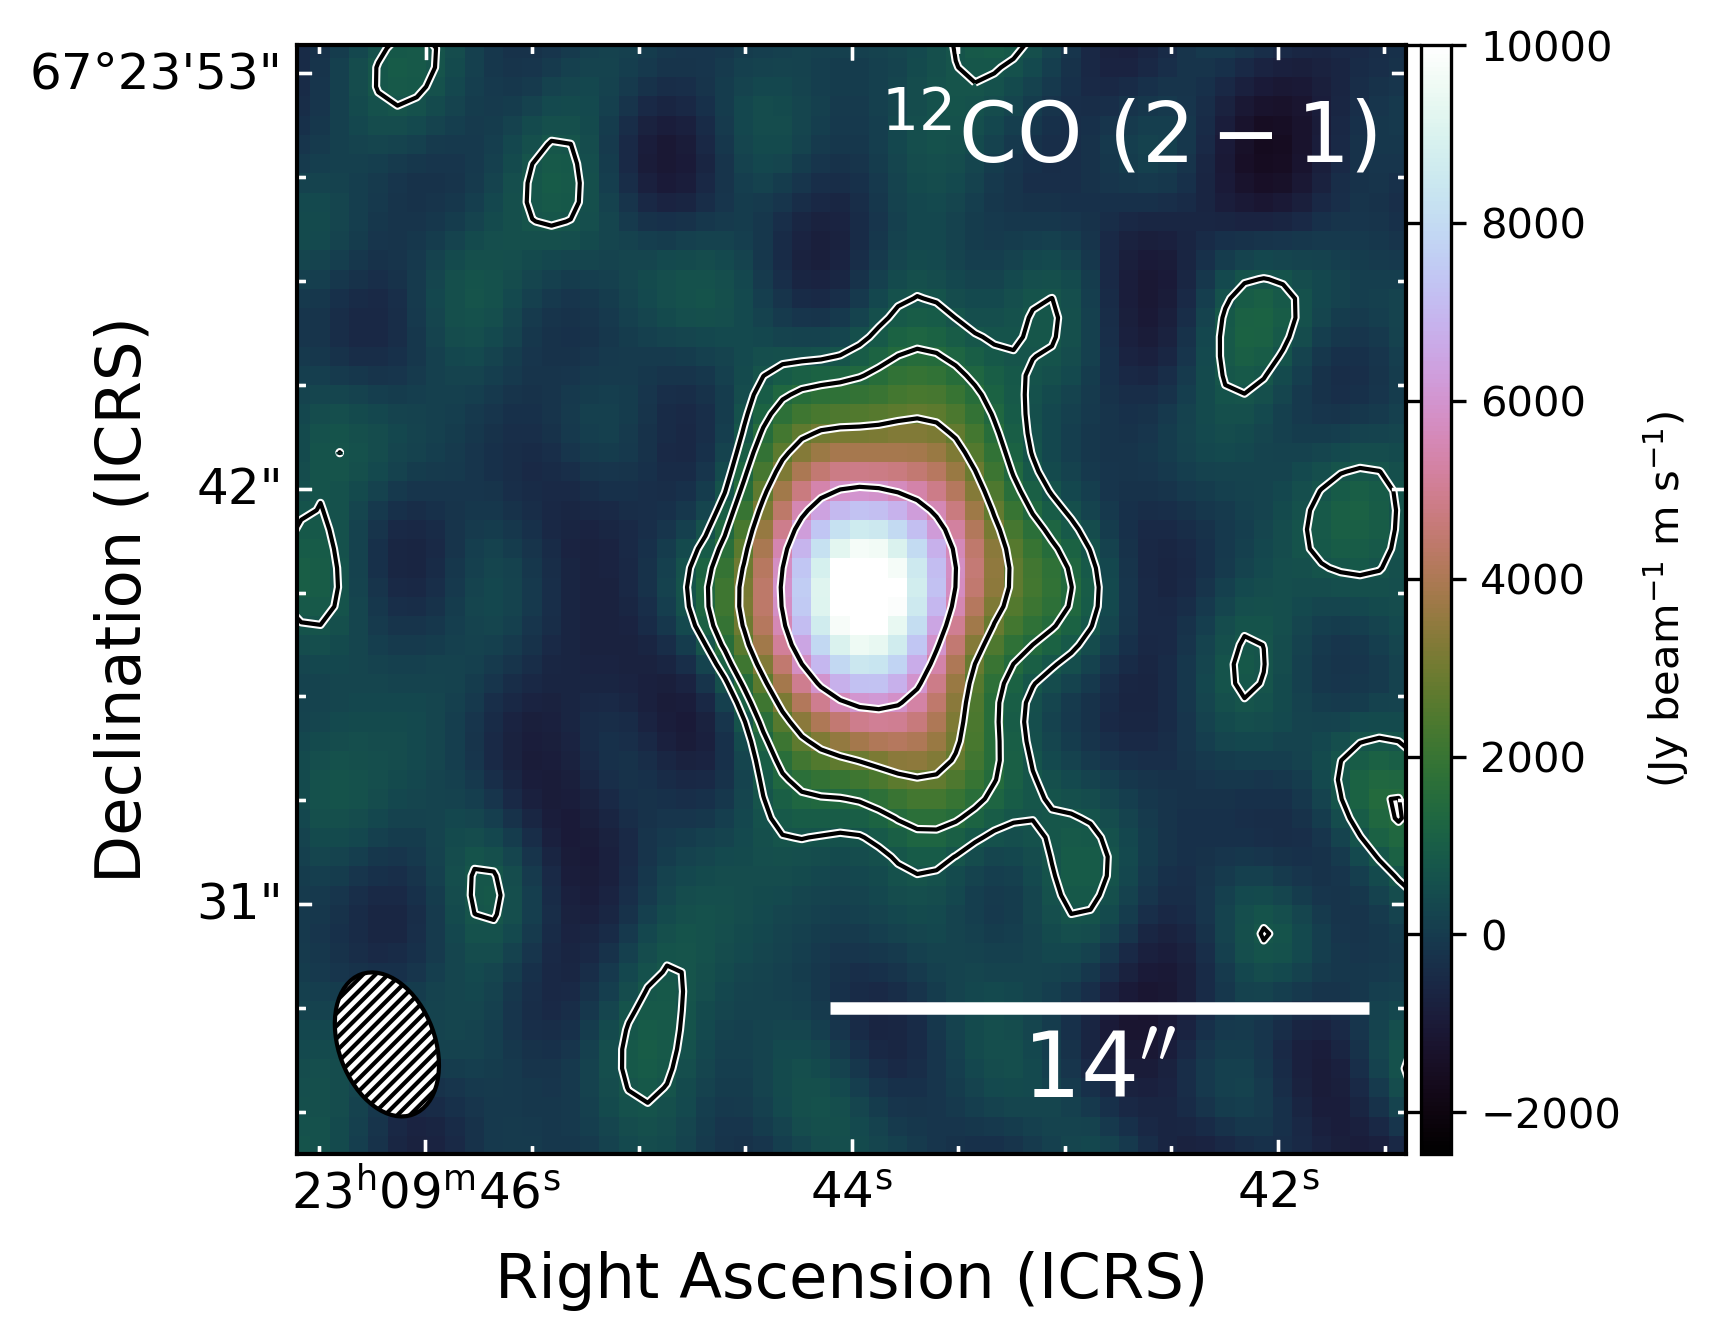

In [16]:
color_table='cubehelix' #cmocean.cm.ice
fig = plt.figure(dpi=300)

mom0_12CO = fits.open('/Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/not_clipped/DraChi.briggs0.12CO.LSRK.im.image_M0.fits')

f_mom0_12CO = aplpy.FITSFigure(mom0_12CO, figure=fig)#, slices=[0],

vmin, vmax = np.nanpercentile(mom0_12CO[0].data, [2, 98])
f_mom0_12CO.show_colorscale(cmap=color_table, vmax=10000) 

#rms = 9.93e-02 # obtained from bettermoments, see above
rms = 2.41e2

# adopt the default layout
figure_layout( f_mom0_12CO, c_unit='(Jy beam$^{-1}$ m s$^{-1}$)')

c_levs = np.array([3, 6, 12, 24])*rms
f_mom0_12CO.show_contour(colors='white', linewidths=2., levels=c_levs)
f_mom0_12CO.show_contour(colors='black', linewidths=1., levels=c_levs)

# got the coordinates of the center from CASAviewer
f_mom0_12CO.recenter(347.432,67.3942,width=0.008,height=0.008)

f_mom0_12CO.add_label(0.75,0.92, '$^{12}$CO $(2-1)$', relative=True, color='white', size=20)


fig.savefig('../plots/moment0/mom0_12CO_unclipped.pdf', bbox_inches='tight')

### Second: Create Moment0 (=integrated intensity) map of 12CO data, but now we're trying to reduce the noise in the data to get a nicer image

In [7]:
!bettermoments /Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/DraChi.briggs0.12CO.LSRK.im.image.fits -method zeroth -clip 2 -firstchannel 26 -lastchannel 48 --returnmask

# -clip 2: mask all pixel with < 2sigma_rms
# -firstchannel 22: start from channel 26, i.e. -4.24km/s
# -lastchannel 50: stop at channel 48, i.e. -12.23 km/s 


Loading up data...
Defining channel-based mask...
Estimating noise in the data...
Estimated RMS: 9.93e-02.
Calculating threshold-based mask...
Masking the data...
Calculating maps...
Checking for NaNs in error maps.
Saving moment maps...


In [8]:
mom0_12CO = fits.open('/Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/DraChi.briggs0.12CO.LSRK.im.image_M0.fits')
mom0_12CO[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  144                                                  
NAXIS2  =                  144                                                  
BMAJ    = 0.001078328424029880                                                  
BMIN    = 0.000693414211273193                                                  
BPA     =            20.496504                                                  
BUNIT   = 'Jy/beam m/s'                                                         
CTYPE1  = 'RA---SIN'                                                            
CRVAL1  =       347.4318541667                                                  
CDELT1  =  -0.0001388888888889                                                  
CRPIX1  =                 73

In [18]:
rms = 2.02e2 # Jy/beam m/s from mom0 map
max_em = 1.04e4 # Jy/beam m/s from mom0 map

INFO: Auto-setting vmin to -2.394e+03 [aplpy.core]


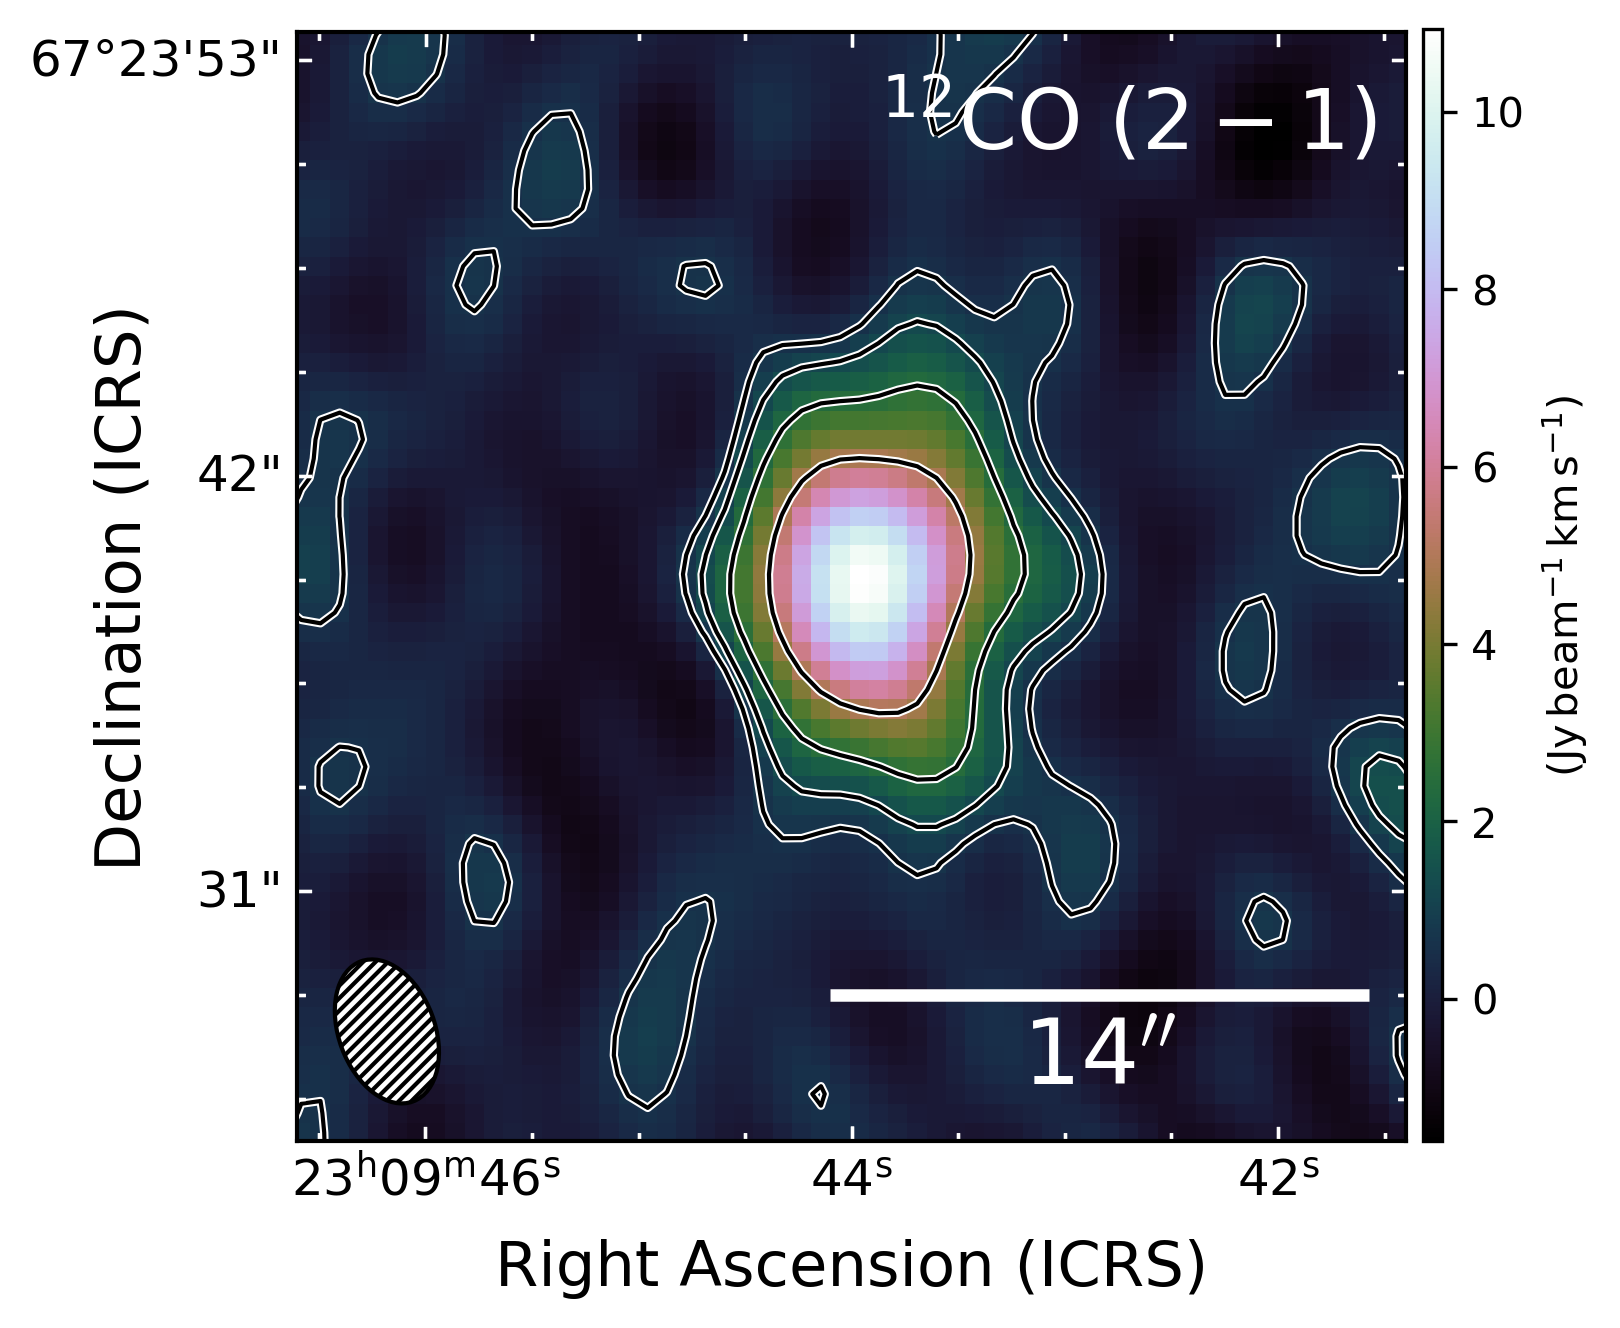

In [19]:
color_table='cubehelix'
fig = plt.figure(dpi=300)

f_mom0_12CO = aplpy.FITSFigure(mom0_12CO, figure=fig)#, slices=[0],

vmin, vmax = np.nanpercentile(mom0_12CO[0].data, [2, 98])
f_mom0_12CO.show_colorscale(cmap=color_table, vmax=10000) 

#rms = 9.93e-02 # obtained from bettermoments, see above
#rms = 2.41e2

# adopt the default layout
figure_layout( f_mom0_12CO, c_unit='(Jy beam$^{-1}$ m s$^{-1}$)', colorbar=False)

c_levs = np.array([3, 6, 12, 24])*rms
f_mom0_12CO.show_contour(colors='white', linewidths=2., levels=c_levs)
f_mom0_12CO.show_contour(colors='black', linewidths=1., levels=c_levs)

# got the coordinates of the center from CASAviewer
f_mom0_12CO.recenter(347.432,67.3942,width=0.008,height=0.008)

f_mom0_12CO.add_label(0.75,0.92, '$^{12}$CO $(2-1)$', relative=True, color='white', size=20)


im = plt.imshow(mom0_12CO[0].data/1000., cmap=color_table)
cb_ax = fig.add_axes([0.81, 0.11, 0.01, 0.772]) #right, top, thickness, length
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('$(\mathrm{Jy\,beam^{-1}\,km\,s^{-1}})$', fontsize=10)

fig.savefig('../plots/moment0/mom0_12CO_3_6_12_24sigma_contours.pdf', bbox_inches='tight')


INFO: Auto-setting vmin to -2.400e+03 [aplpy.core]


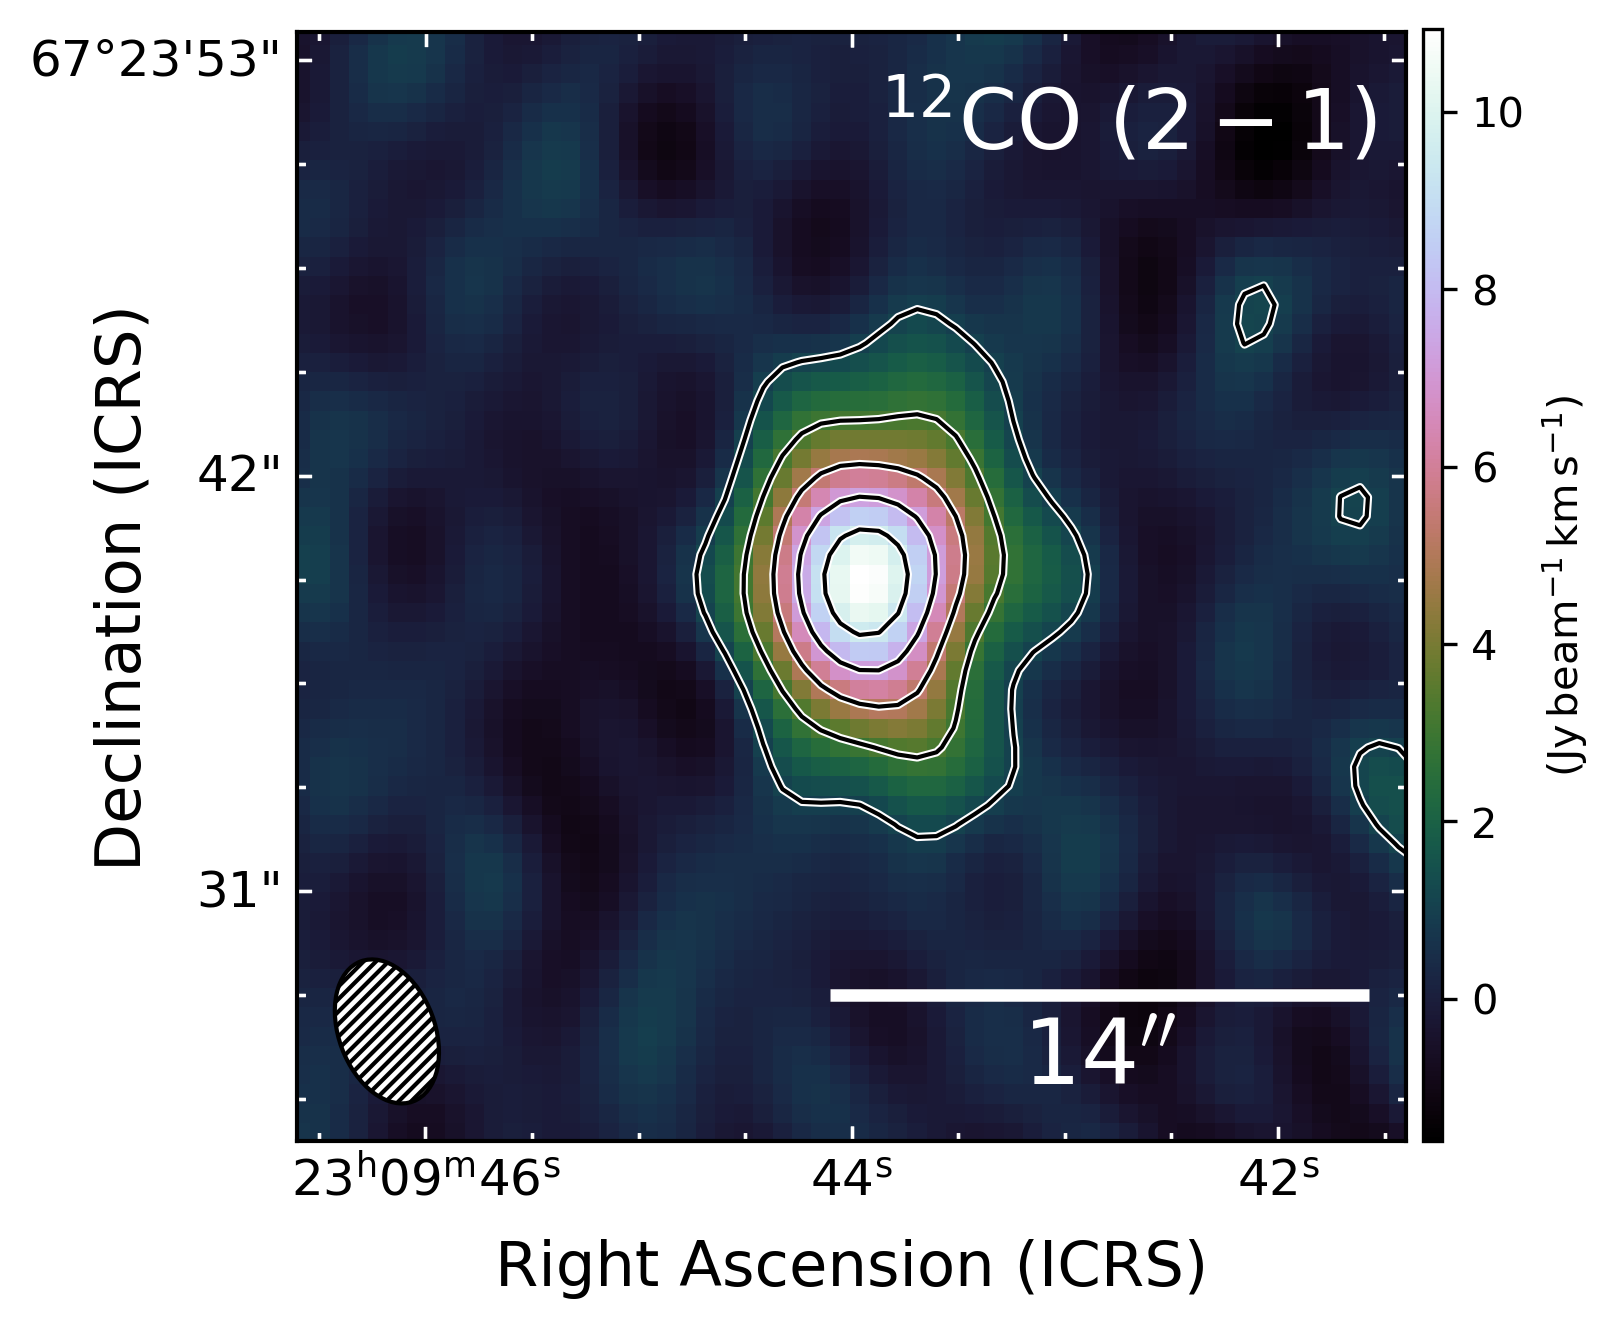

In [20]:
color_table='cubehelix'
fig = plt.figure(dpi=300)

f_mom0_12CO = aplpy.FITSFigure(mom0_12CO, figure=fig)#, slices=[0],

vmin, vmax = np.nanpercentile(mom0_12CO[0].data, [2, 98])
f_mom0_12CO.show_colorscale(cmap=color_table, vmax=10000) 

c_levs = np.arange(0.1,1.2,0.2)*max_em

# adopt the default layout
figure_layout( f_mom0_12CO, c_unit='(Jy beam$^{-1}$ m s$^{-1}$)', colorbar=False)

f_mom0_12CO.show_contour(colors='white', linewidths=2., levels=c_levs)
f_mom0_12CO.show_contour(colors='black', linewidths=1., levels=c_levs)

# got the coordinates of the center from CASAviewer
f_mom0_12CO.recenter(347.432,67.3942,width=0.008,height=0.008)

f_mom0_12CO.add_label(0.75,0.92, '$^{12}$CO $(2-1)$', relative=True, color='white', size=20)


im = plt.imshow(mom0_12CO[0].data/1000., cmap=color_table)
cb_ax = fig.add_axes([0.81, 0.11, 0.01, 0.772]) #right, top, thickness, length
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('$(\mathrm{Jy\,beam^{-1}\,km\,s^{-1}})$', fontsize=10)

fig.savefig('../plots/moment0/mom0_12CO_10_30_etc_maxem_contours.pdf', bbox_inches='tight')

INFO: Auto-setting vmin to -2.421e+03 [aplpy.core]


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


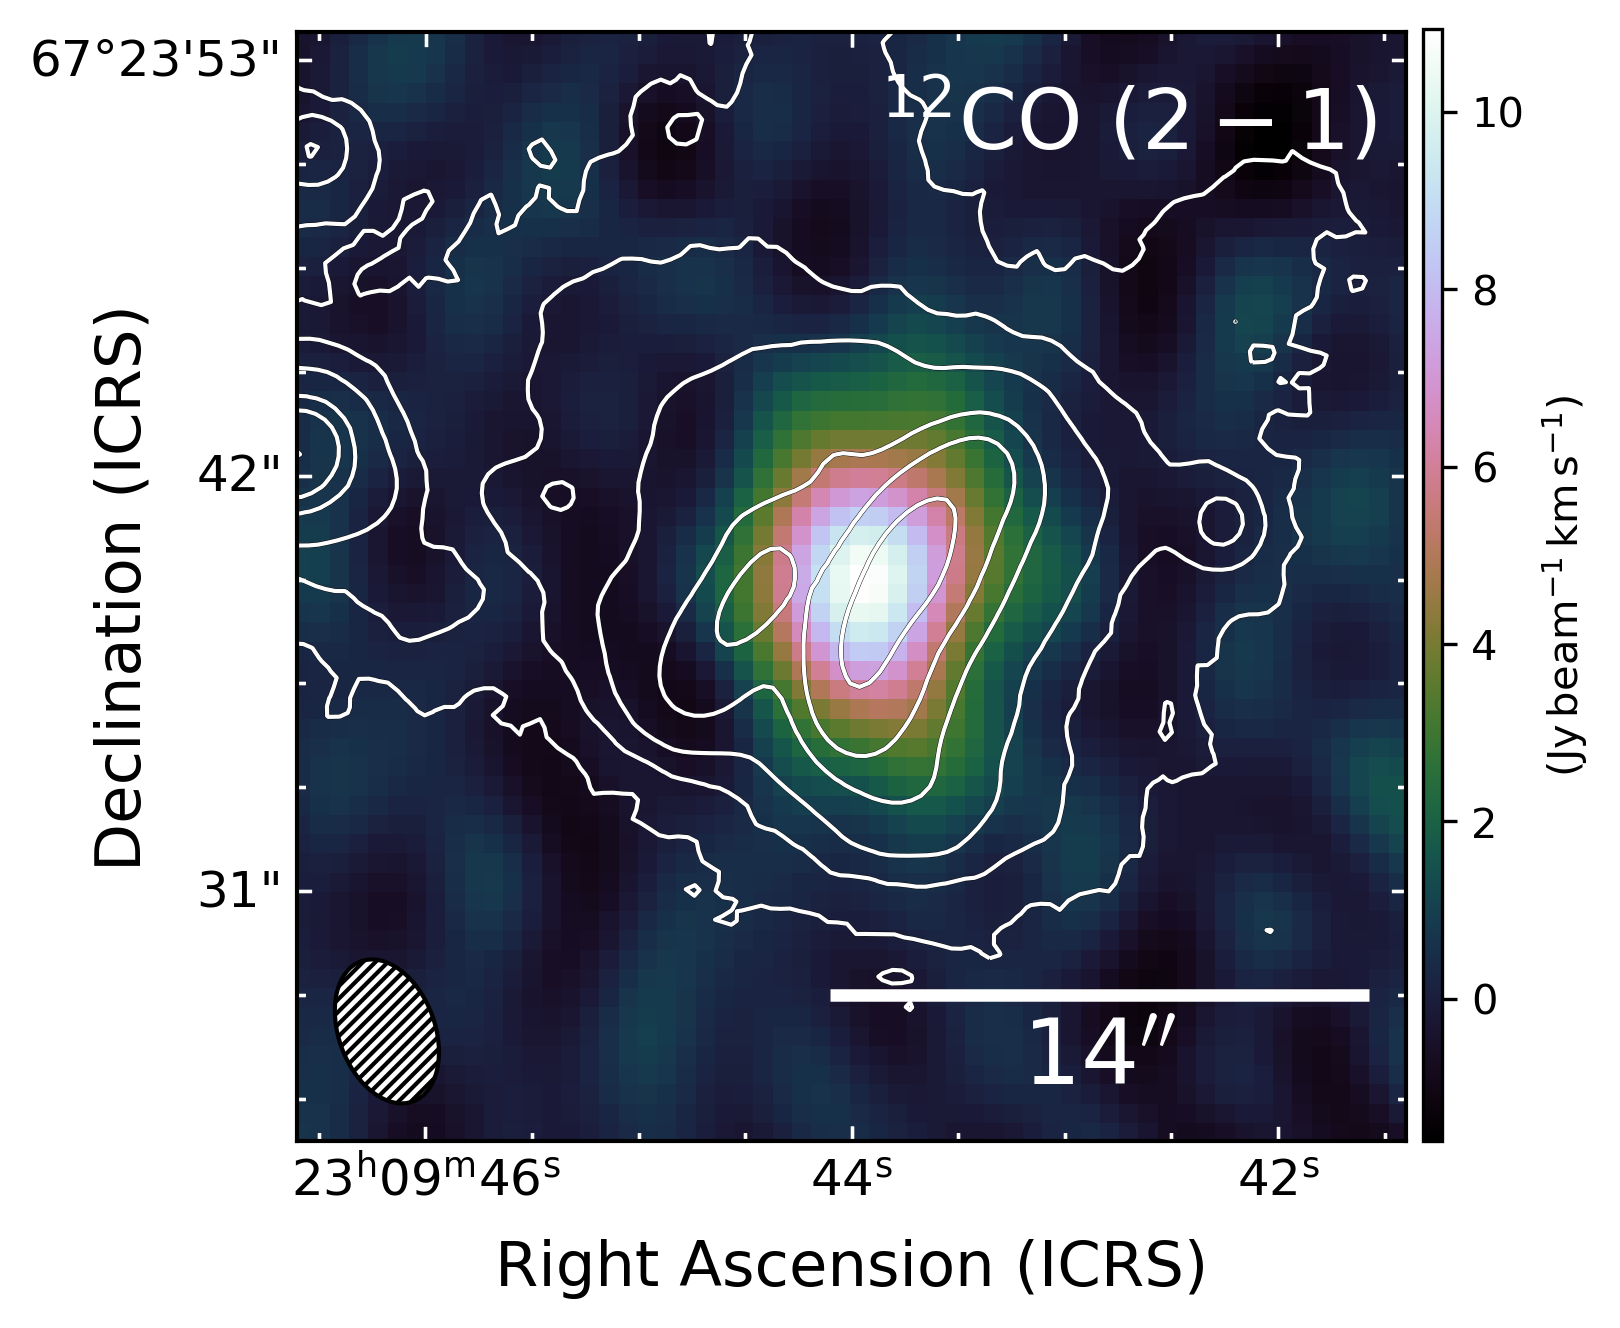

In [21]:
color_table='cubehelix'
fig = plt.figure(dpi=300)

f_mom0_12CO = aplpy.FITSFigure(mom0_12CO, figure=fig)#, slices=[0],

vmin, vmax = np.nanpercentile(mom0_12CO[0].data, [2, 98])
f_mom0_12CO.show_colorscale(cmap=color_table, vmax=10000) 

c_levs = np.arange(0.1,1.2,0.2)*max_em

# adopt the default layout
figure_layout( f_mom0_12CO, c_unit='(Jy beam$^{-1}$ m s$^{-1}$)', colorbar=False)

rms_PS1 = 17.
c_levs = np.array([4, 16, 40, 160, 400, 1600])*rms_PS1
f_mom0_12CO.show_contour('/Users/kristina/Hamburgers/Draculas_Chivito/Pan-STARRS_fits_files/cutout_rings.v3.skycell.2537.088.stk.g.unconv.fits', colors='black', linewidths=1.2, levels=c_levs, smooth=3, kernel='box')
f_mom0_12CO.show_contour('/Users/kristina/Hamburgers/Draculas_Chivito/Pan-STARRS_fits_files/cutout_rings.v3.skycell.2537.088.stk.g.unconv.fits', colors='white', linewidths=1., levels=c_levs, smooth=3, kernel='box')

#f_mom0_12CO.show_contour(colors='white', linewidths=2., levels=c_levs)
#f_mom0_12CO.show_contour(colors='black', linewidths=1., levels=c_levs)

# got the coordinates of the center from CASAviewer
f_mom0_12CO.recenter(347.432,67.3942,width=0.008,height=0.008)

f_mom0_12CO.add_label(0.75,0.92, '$^{12}$CO $(2-1)$', relative=True, color='white', size=20)


im = plt.imshow(mom0_12CO[0].data/1000., cmap=color_table)
cb_ax = fig.add_axes([0.81, 0.11, 0.01, 0.772]) #right, top, thickness, length
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('$(\mathrm{Jy\,beam^{-1}\,km\,s^{-1}})$', fontsize=10)

fig.savefig('../plots/moment0/mom0_12CO_PS1_contours.pdf', bbox_inches='tight')

### Now: create Moment1 (=centroid velocity v_lsr) map of 12CO

In [22]:
!bettermoments /Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/DraChi.briggs0.12CO.LSRK.im.image.fits -clip 5
# use the quadratic method (default), rather than calculating the classic mom1 map


Loading up data...
Estimating noise in the data...
Estimated RMS: 9.93e-02.
Calculating threshold-based mask...
Masking the data...
Calculating maps...
Checking for NaNs in error maps.
Saving moment maps...


In [23]:
mom1_12CO = fits.open('/Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/DraChi.briggs0.12CO.LSRK.im.image_v0.fits')

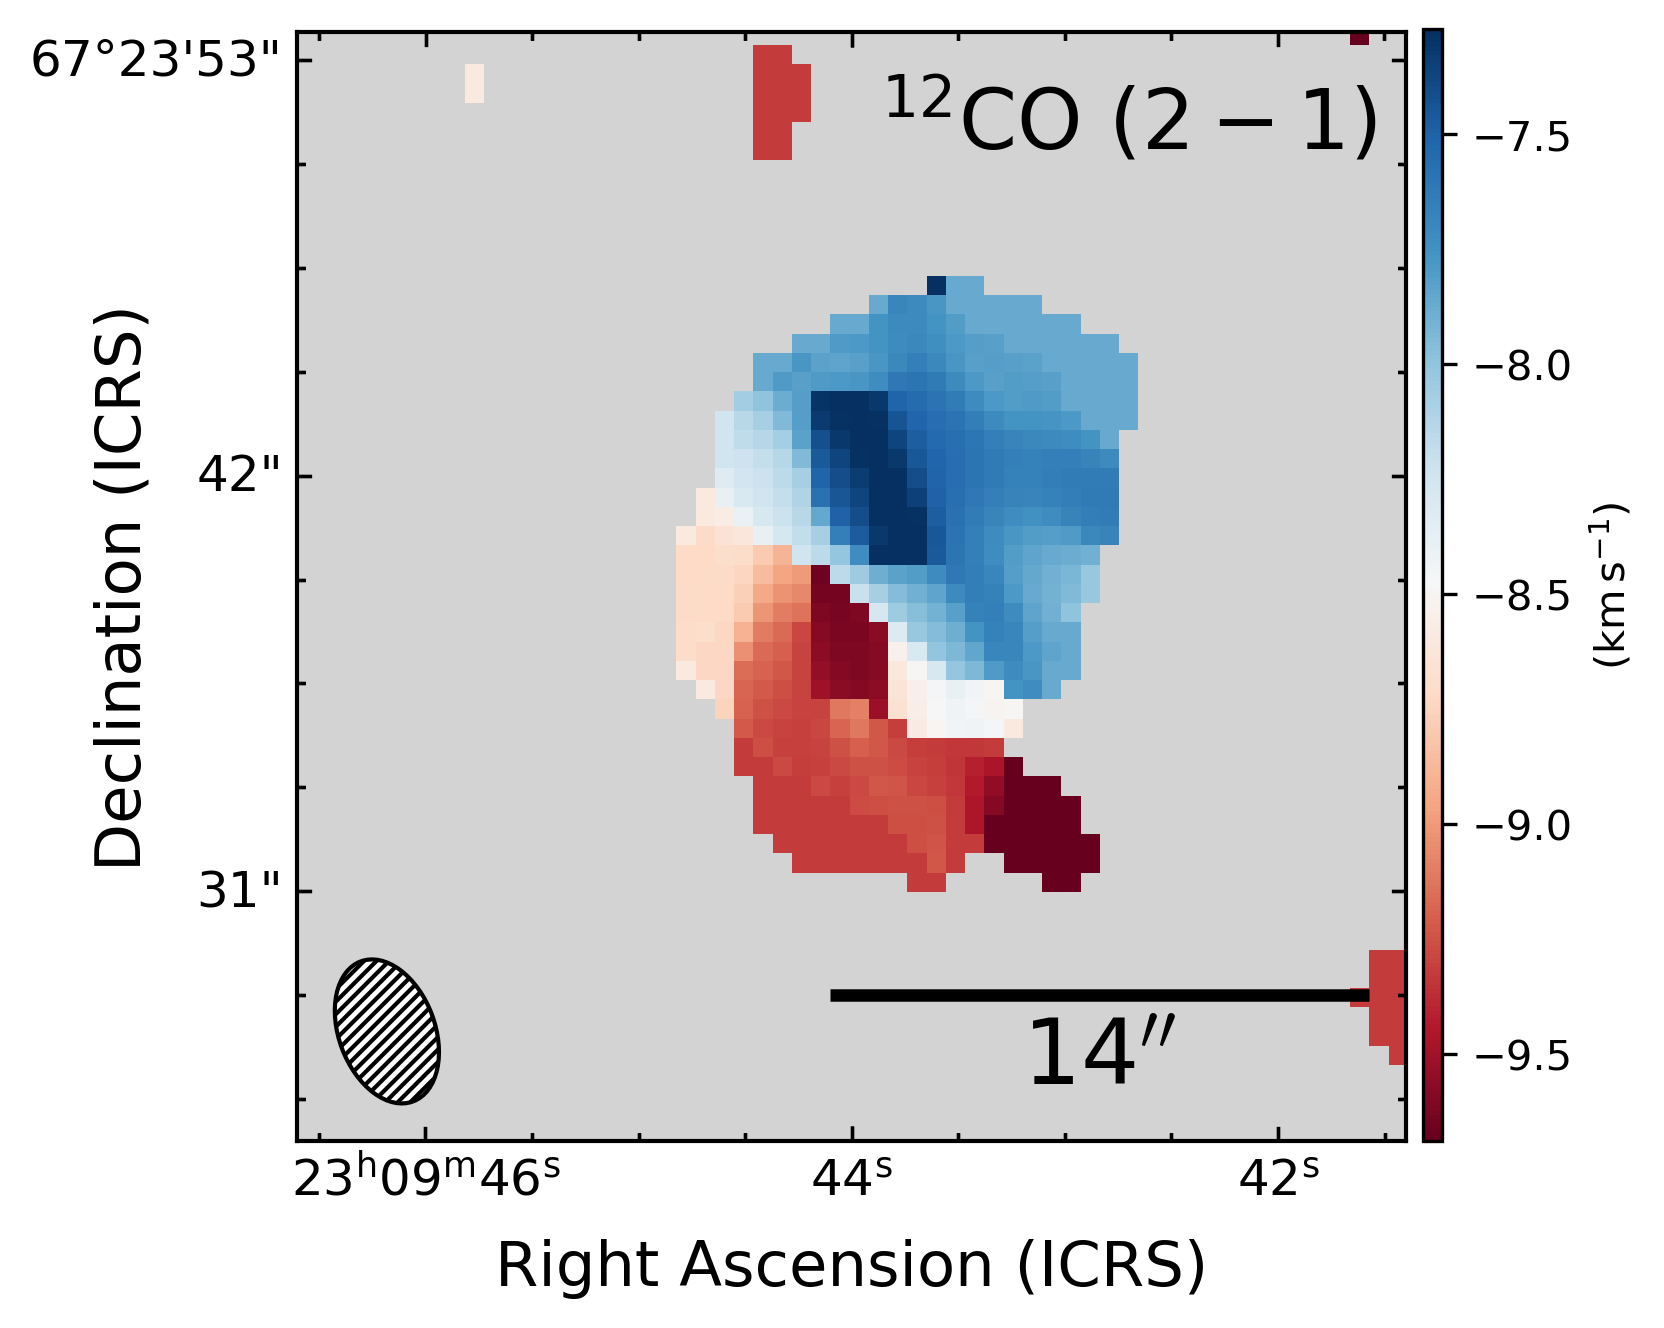

In [24]:
color_table='RdBu'
fig = plt.figure(dpi=300)

f_mom1_12CO = aplpy.FITSFigure(mom1_12CO, figure=fig)#, slices=[0],

vmin, vmax = np.nanpercentile(mom1_12CO[0].data, [2, 98])
f_mom1_12CO.show_colorscale(cmap=color_table, vmin=vmin, vmax=vmax) 

# adopt the default layout
figure_layout( f_mom1_12CO, c_unit='(m s$^{-1}$)', fontcolor='black', colorbar=False)

# got the coordinates of the center from CASAviewer
f_mom1_12CO.recenter(347.432,67.3942,width=0.008,height=0.008)

f_mom1_12CO.add_label(0.75,0.92, '$^{12}$CO $(2-1)$', relative=True, color='black', size=20)


im = plt.imshow(mom1_12CO[0].data/1000., cmap=color_table, vmin=vmin/1000, vmax=vmax/1000)
cb_ax = fig.add_axes([0.81, 0.11, 0.01, 0.772]) #right, top, thickness, length
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('$(\mathrm{km\,s^{-1}})$', fontsize=10)

f_mom1_12CO.set_nan_color('lightgrey')


fig.savefig('../plots/moment1/mom1_12CO.pdf', bbox_inches='tight')


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


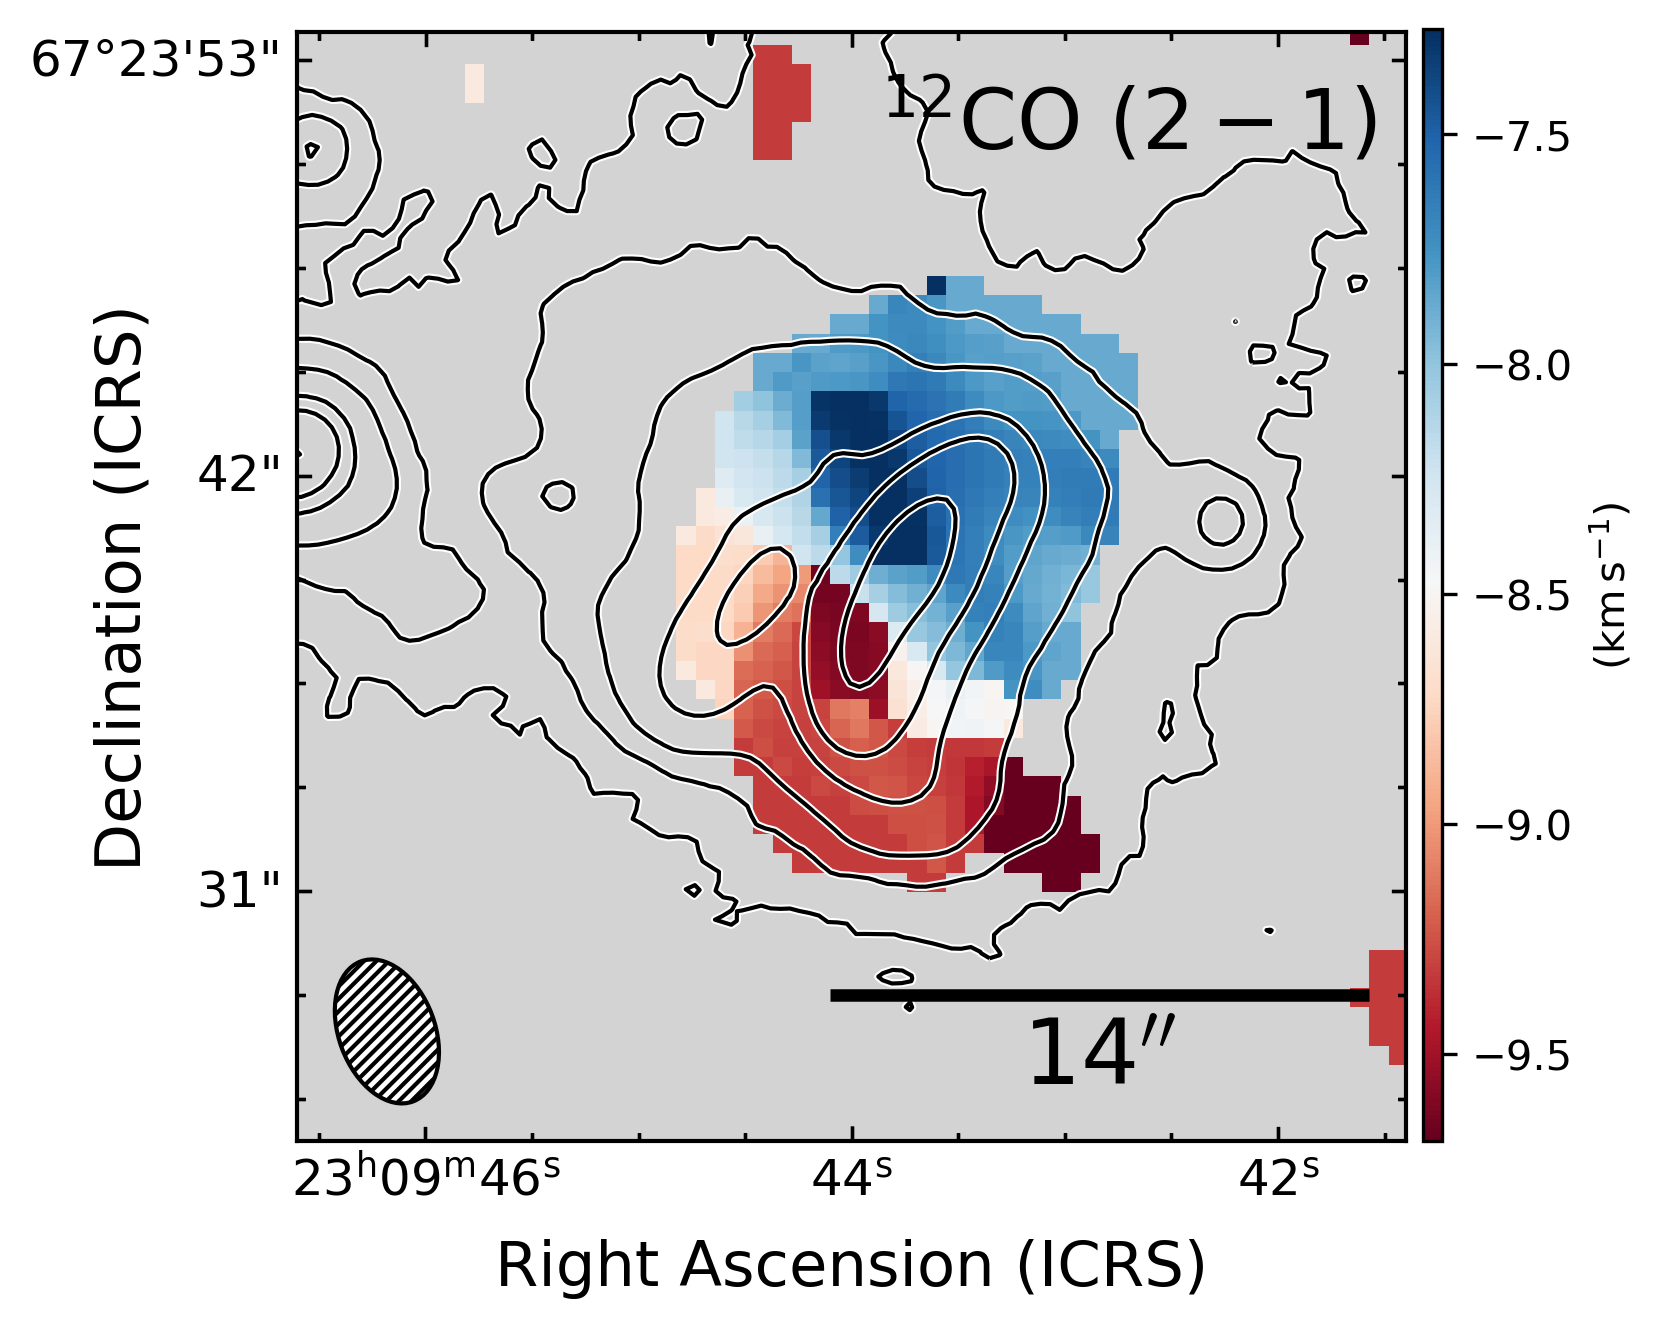

In [26]:
color_table='RdBu'
fig = plt.figure(dpi=300)

f_mom1_12CO = aplpy.FITSFigure(mom1_12CO, figure=fig)#, slices=[0],

vmin, vmax = np.nanpercentile(mom1_12CO[0].data, [2, 98])
f_mom1_12CO.show_colorscale(cmap=color_table, vmin=vmin, vmax=vmax) 

# adopt the default layout
figure_layout( f_mom1_12CO, c_unit='(m s$^{-1}$)', fontcolor='black', colorbar=False)

c_levs = np.array([4, 16, 40, 160, 400, 1600])*rms_PS1
f_mom1_12CO.show_contour('/Users/kristina/Hamburgers/Draculas_Chivito/Pan-STARRS_fits_files/cutout_rings.v3.skycell.2537.088.stk.g.unconv.fits', colors='white', linewidths=2., levels=c_levs, smooth=3, kernel='box')
f_mom1_12CO.show_contour('/Users/kristina/Hamburgers/Draculas_Chivito/Pan-STARRS_fits_files/cutout_rings.v3.skycell.2537.088.stk.g.unconv.fits', colors='black', linewidths=1, levels=c_levs, smooth=3, kernel='box')


# got the coordinates of the center from CASAviewer
f_mom1_12CO.recenter(347.432,67.3942,width=0.008,height=0.008)

f_mom1_12CO.add_label(0.75,0.92, '$^{12}$CO $(2-1)$', relative=True, color='black', size=20)


im = plt.imshow(mom1_12CO[0].data/1000., cmap=color_table, vmin=vmin/1000, vmax=vmax/1000)
cb_ax = fig.add_axes([0.81, 0.11, 0.01, 0.772]) #right, top, thickness, length
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('$(\mathrm{km\,s^{-1}})$', fontsize=10)

f_mom1_12CO.set_nan_color('lightgrey')


fig.savefig('../plots/moment1/mom1_12CO_PS1contours.pdf', bbox_inches='tight')




In [27]:
mom0_12CO[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  144                                                  
NAXIS2  =                  144                                                  
BMAJ    = 0.001078328424029880                                                  
BMIN    = 0.000693414211273193                                                  
BPA     =            20.496504                                                  
BUNIT   = 'Jy/beam m/s'                                                         
CTYPE1  = 'RA---SIN'                                                            
CRVAL1  =       347.4318541667                                                  
CDELT1  =  -0.0001388888888889                                                  
CRPIX1  =                 73

In [28]:
print(mom0_12CO[0].header['BMAJ']*3600)  
print(mom0_12CO[0].header['BMIN']*3600)   
print(mom0_12CO[0].header['BPA'])  

3.881982326507568
2.4962911605834948
20.496504


## Plot channel map

### 1st: add keywords for beam to header

In [29]:
from astropy.utils.data import get_pkg_data_filename

cube_file = '/Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/DraChi.briggs0.12CO.LSRK.im.image_modified_header.fits'

fits_file = get_pkg_data_filename(cube_file)
#fits.info(fits_file)

# got these values from the mom0 file...don't know why the cube doesn't have them
fits.setval(fits_file, 'BMAJ', value=mom0_12CO[0].header['BMAJ'])
fits.setval(fits_file, 'BMIN', value=mom0_12CO[0].header['BMIN'])
fits.setval(fits_file, 'BPA', value=mom0_12CO[0].header['BPA'])

### 2nd: Zoom into the central region of the data cube

In [30]:
from astropy.wcs import wcs

data_file = fits.open(cube_file)[0]
data, header = data_file.data, data_file.header

# got this coordinates from Casaviewer
x_center = 347.432
y_center = 67.3941
w = wcs.WCS(header, naxis=(1,2))

print(w)

#Convert center value to pixel coordinates
pixcrd = w.wcs_world2pix(np.vstack((x_center,y_center)).T, 1)[0]
print(pixcrd)

print(w.wcs_pix2world(np.vstack((72.59639019, 72.64000047)).T,1))

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 347.4318541667  67.39415  
CRPIX : 73.0  73.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0001388888888889  0.0001388888888889  
NAXIS : 144  144  60  1
[72.59639019 72.64000047]
[[347.432   67.3941]]


Set OBSGEO-B to    19.947177 from OBSGEO-[XYZ].
Set OBSGEO-H to     6578.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [31]:
from spectral_cube import SpectralCube

# 12CO J = 2−1 rest frequency (230.538 GHz) from Andrews+2018
# 2.305380000000E+11 /Rest Frequency (Hz) from fits-file header of 12CO cube
cube_contour = SpectralCube.read(cube_file, format='fits')
cube_contour = cube_contour.with_spectral_unit(unit=u.km/u.s, rest_value=mom0_12CO[0].header['RESTFRQ']/1e9*u.GHz, velocity_convention='radio')
cube_contour._unit = u.Jy/u.beam

cube_contour

VaryingResolutionSpectralCube with shape=(60, 144, 144) and unit=Jy / beam:
 n_x:    144  type_x: RA---SIN  unit_x: deg    range:   347.406190 deg:  347.457880 deg
 n_y:    144  type_y: DEC--SIN  unit_y: deg    range:    67.384148 deg:   67.404009 deg
 n_s:     60  type_s: VRAD      unit_s: km / s  range:      -16.227 km / s:       5.202 km / s

In [32]:
import pyspeckit

#xwidth and ywidth are radii in pixel units of the data cube
cutout_cube = pyspeckit.cubes.subcube(cube_contour, xcen=pixcrd[0], ycen=pixcrd[1], xwidth=25, ywidth=25)
cutout_cube.header['CDELT3']

-0.36319867730252003

In [33]:
cutout_cube.header

SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    3                                                  
NAXIS1  =                   51                                                  
NAXIS2  =                   51                                                  
NAXIS3  =                   60                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = 'DraChi  '                                                            
BUNIT   = 'Jy beam-1'          / Brightness (pixel) unit                        
ALTRVAL =   5.201614623220E+

### 3rd: Plot channel map

In [59]:
import matplotlib.patheffects as pe

def channel_map_layout(fig, rms, slice, label='', fontcolor='black', plot_xlabel=True, plot_ylabel=False, plot_cbar=False):
    fig.set_nan_color('0.95')
    
    # beam 
    fig.add_beam()
    fig.beam.set(facecolor='white', edgecolor='black', hatch='////////', lw=0.5)
        
    fig.axis_labels.set_font(size=6)
    fig.axis_labels.set_xtext('RA')
    fig.tick_labels.set_yformat('d.ddd')
    fig.axis_labels.set_ytext('DEC')
    fig.tick_labels.set_xformat('d.ddd')
    fig.axis_labels.set_ypad(pad=-1.5)
    
    fig.ticks.set_color(fontcolor)
    fig.ticks.set_tick_direction('in')
    fig.tick_labels.set_font(size=6)
    #fig.ticks.set_minor_frequency(2)
    fig.ticks.set_yspacing(0.002)  # degrees
    fig.ticks.set_xspacing(0.01)  # degrees
    
    fig.axis_labels.hide_x()
    fig.axis_labels.hide_y()
    
    if plot_xlabel==False:
        fig.tick_labels.hide_x()
        
    if plot_ylabel==False:
        fig.tick_labels.hide_y()
        
    if plot_cbar:
        fig.add_colorbar()
        fig.colorbar.set_location('right')
        fig.colorbar.set_width(0.05)
        fig.colorbar.set_pad(0.5)
        fig.colorbar.set_axis_label_text('(Jy beam$^{-1}$)')
        
    c_levs = np.array([3, 6, 12, 18])*rms
    fig.show_contour(cube_contour[slice].hdu, colors='white', linewidths=1, levels=c_levs)
    fig.show_contour(cube_contour[slice].hdu, colors='black', linewidths=0.75, levels=c_levs)
    
    fig.add_label(0.67, 0.9, label, relative=True, color=fontcolor, size=6, path_effects=[pe.withStroke(linewidth=1.5, foreground="white")])


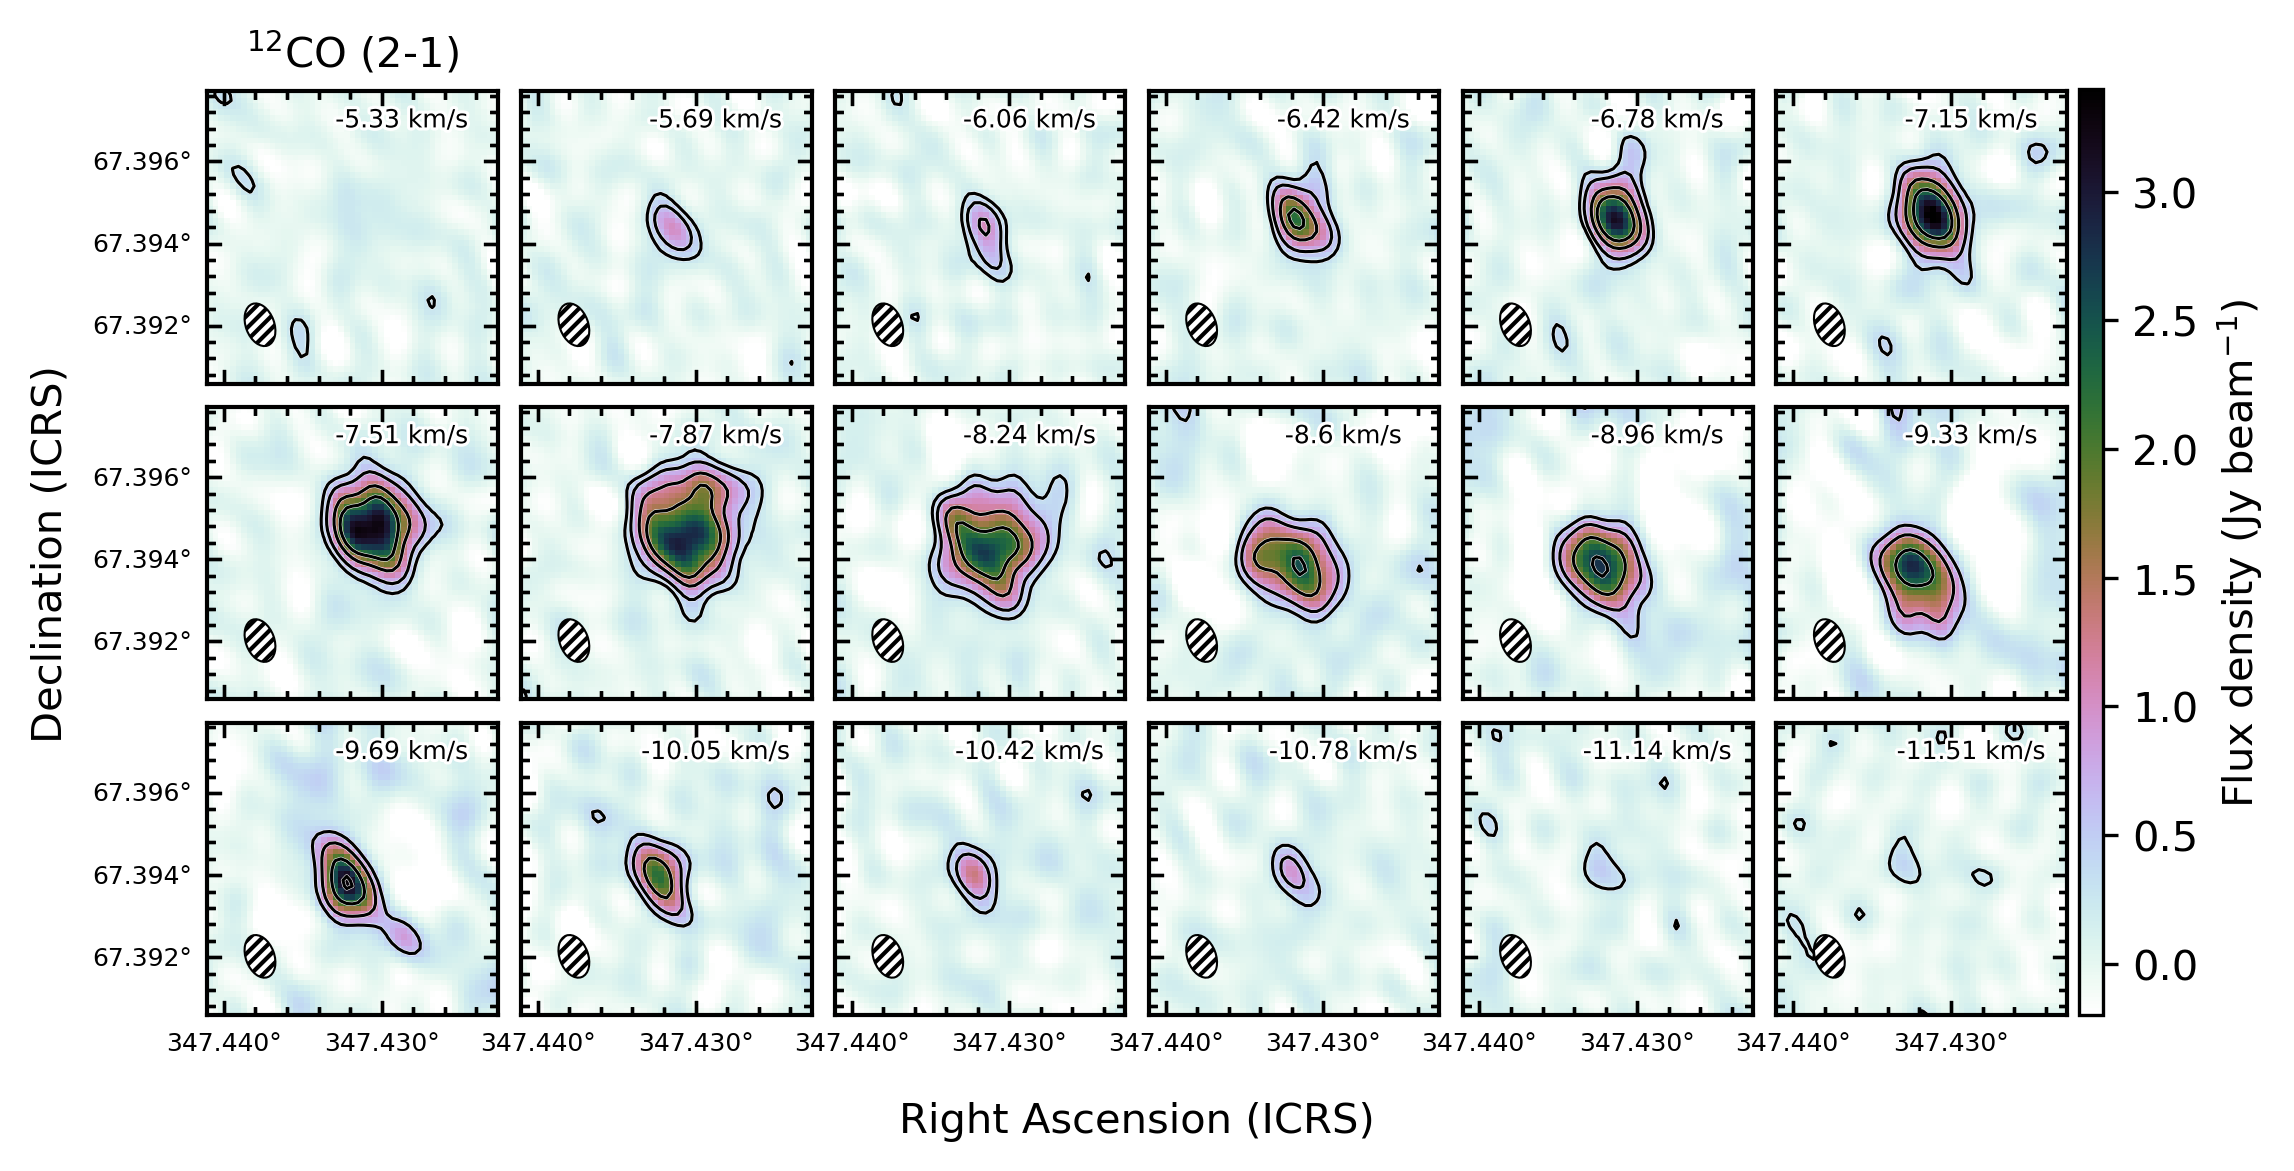

In [61]:
import matplotlib.gridspec as gridspec
import cmocean 

fig = plt.figure(dpi=300, figsize=(8,4))

color_table='cubehelix_r'
#color_table=cmocean.cm.ice_r

gridspec_layout = gridspec.GridSpec(3,6)
gridspec_layout.update(hspace=0.08, wspace=0.08)

#rms_bm = 9.93e-02 # Jy/beam m/s; mean RMS determined from bettermoments

### FIRST ROW
channel=29
rms = 9.04e-2
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_0 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[0].get_position(fig).bounds))
f_cube_12CO_0.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_0, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=False, plot_ylabel=True, plot_cbar=False)
f_cube_12CO_0.set_title('$^{12}$CO (2-1)', fontsize=10)

channel+=1
rms = 9.43e-2
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_1 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[1].get_position(fig).bounds))
f_cube_12CO_1.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_1, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=False, plot_ylabel=False, plot_cbar=False)

channel+=1
rms = 8.15e-2
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_2 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[2].get_position(fig).bounds))
f_cube_12CO_2.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_2, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=False, plot_ylabel=False, plot_cbar=False)

channel+=1
rms = 1.13e-1
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_3 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[3].get_position(fig).bounds))
f_cube_12CO_3.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_3, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=False, plot_ylabel=False, plot_cbar=False)

channel+=1
rms = 1.05e-1
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_4 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[4].get_position(fig).bounds))
f_cube_12CO_4.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_4, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=False, plot_ylabel=False, plot_cbar=False)

channel+=1
rms = 1.24e-1
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_5 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[5].get_position(fig).bounds))
f_cube_12CO_5.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_5, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=False, plot_ylabel=False, plot_cbar=False)

### SECOND ROW
channel+=1
rms = 1.16e-1
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_6 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[6].get_position(fig).bounds))
f_cube_12CO_6.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_6, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=False, plot_ylabel=True, plot_cbar=False)

channel+=1
rms = 9.18e-2
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_7 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[7].get_position(fig).bounds))
f_cube_12CO_7.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_7, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=False, plot_ylabel=False, plot_cbar=False)

channel+=1
rms = 1.07e-1
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_8 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[8].get_position(fig).bounds))
f_cube_12CO_8.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_8, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=False, plot_ylabel=False, plot_cbar=False)

channel+=1
rms = 1.35e-1
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_9 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[9].get_position(fig).bounds))
f_cube_12CO_9.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_9, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=False, plot_ylabel=False, plot_cbar=False)

channel+=1
rms = 1.48e-1
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_10 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[10].get_position(fig).bounds))
f_cube_12CO_10.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_10, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=False, plot_ylabel=False, plot_cbar=False)

channel+=1
rms = 1.84e-1
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_11 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[11].get_position(fig).bounds))
f_cube_12CO_11.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_11, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=False, plot_ylabel=False, plot_cbar=False)


### THIRD ROW
channel+=1
rms = 1.77e-1
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_12 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[12].get_position(fig).bounds))
f_cube_12CO_12.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_12, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=True, plot_ylabel=True, plot_cbar=False)

channel+=1
rms = 1.33e-1
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_13 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[13].get_position(fig).bounds))
f_cube_12CO_13.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_13, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=True, plot_ylabel=False, plot_cbar=False)

channel+=1
rms = 1.17e-1
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_14 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[14].get_position(fig).bounds))
f_cube_12CO_14.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_14, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=True, plot_ylabel=False, plot_cbar=False)

channel+=1
rms = 1.19e-1
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_15 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[15].get_position(fig).bounds))
f_cube_12CO_15.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_15, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=True, plot_ylabel=False, plot_cbar=False)

channel+=1
rms = 9.28e-2
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_16 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[16].get_position(fig).bounds))
f_cube_12CO_16.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_16, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=True, plot_ylabel=False, plot_cbar=False)

channel+=1
rms = 7.40e-2
channel_vel_cen = cutout_cube.header['CRVAL3']+channel*cutout_cube.header['CDELT3']
f_cube_12CO_17 = aplpy.FITSFigure(cutout_cube.hdulist, slices=[channel], dimensions=[0,1], figure=fig, subplot=list(gridspec_layout[17].get_position(fig).bounds))
f_cube_12CO_17.show_colorscale(cmap=color_table, vmin=-0.2, vmax=3.4) 
channel_map_layout(f_cube_12CO_17, rms=rms, slice=channel, label='{0} km/s'.format(np.round(channel_vel_cen, 2)), fontcolor='black', plot_xlabel=True, plot_ylabel=False, plot_cbar=False)

fig.subplots_adjust(wspace=0.05)
#fig.subplots_adjust(hspace=0.01)

#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.085, 0.05, 0.7])
#fig.colorbar(f_cube_12CO_17, cax=cbar_ax)

# add an axes, lower left corner in [0.83, 0.08] measured in figure coordinate with axes width 0.02 and height 0.8

im = plt.imshow(cutout_cube[channel].data, cmap=color_table, vmin=-0.2, vmax=3.4)
cb_ax = fig.add_axes([0.905, 0.11, 0.01, 0.772]) #right, top, thickness, length
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Flux density (Jy beam$^{-1}$)', fontsize=10)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Right Ascension (ICRS)")
plt.ylabel("Declination (ICRS)", labelpad=10)

fig.savefig('../plots/channel_maps/channel_12CO.pdf', bbox_inches='tight')


### Get the pixel scale

In [58]:
from astropy import wcs

ww2 = wcs.WCS(mom0_12CO[0].header)

#wcs.utils.non_celestial_pixel_scales(ww2)

wcs.utils.proj_plane_pixel_scales(ww2)

array([0.00013889, 0.00013889])

In [59]:
(0.00013889*u.deg).to(u.arcsec) # arcsec per pixel

<Quantity 0.500004 arcsec>

## maximum emission

In [61]:
!bettermoments /Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/not_clipped/DraChi.briggs0.12CO.LSRK.im.image.fits -method eighth

Loading up data...
Estimating noise in the data...
Estimated RMS: 9.93e-02.
Masking the data...
Calculating maps...
Checking for NaNs in error maps.
Saving moment maps...


In [62]:
!bettermoments /Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/not_clipped/DraChi.briggs0.12CO.LSRK.im.image.fits 


Loading up data...
Estimating noise in the data...
Estimated RMS: 9.93e-02.
Masking the data...
Calculating maps...
Checking for NaNs in error maps.
Saving moment maps...


In [63]:
max_12CO = fits.open('/Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/not_clipped/DraChi.briggs0.12CO.LSRK.im.image_Fnu.fits')
mom8_12CO = fits.open('/Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/not_clipped/DraChi.briggs0.12CO.LSRK.im.image_M8.fits')

INFO: Auto-setting vmin to -1.000e+03 [aplpy.core]


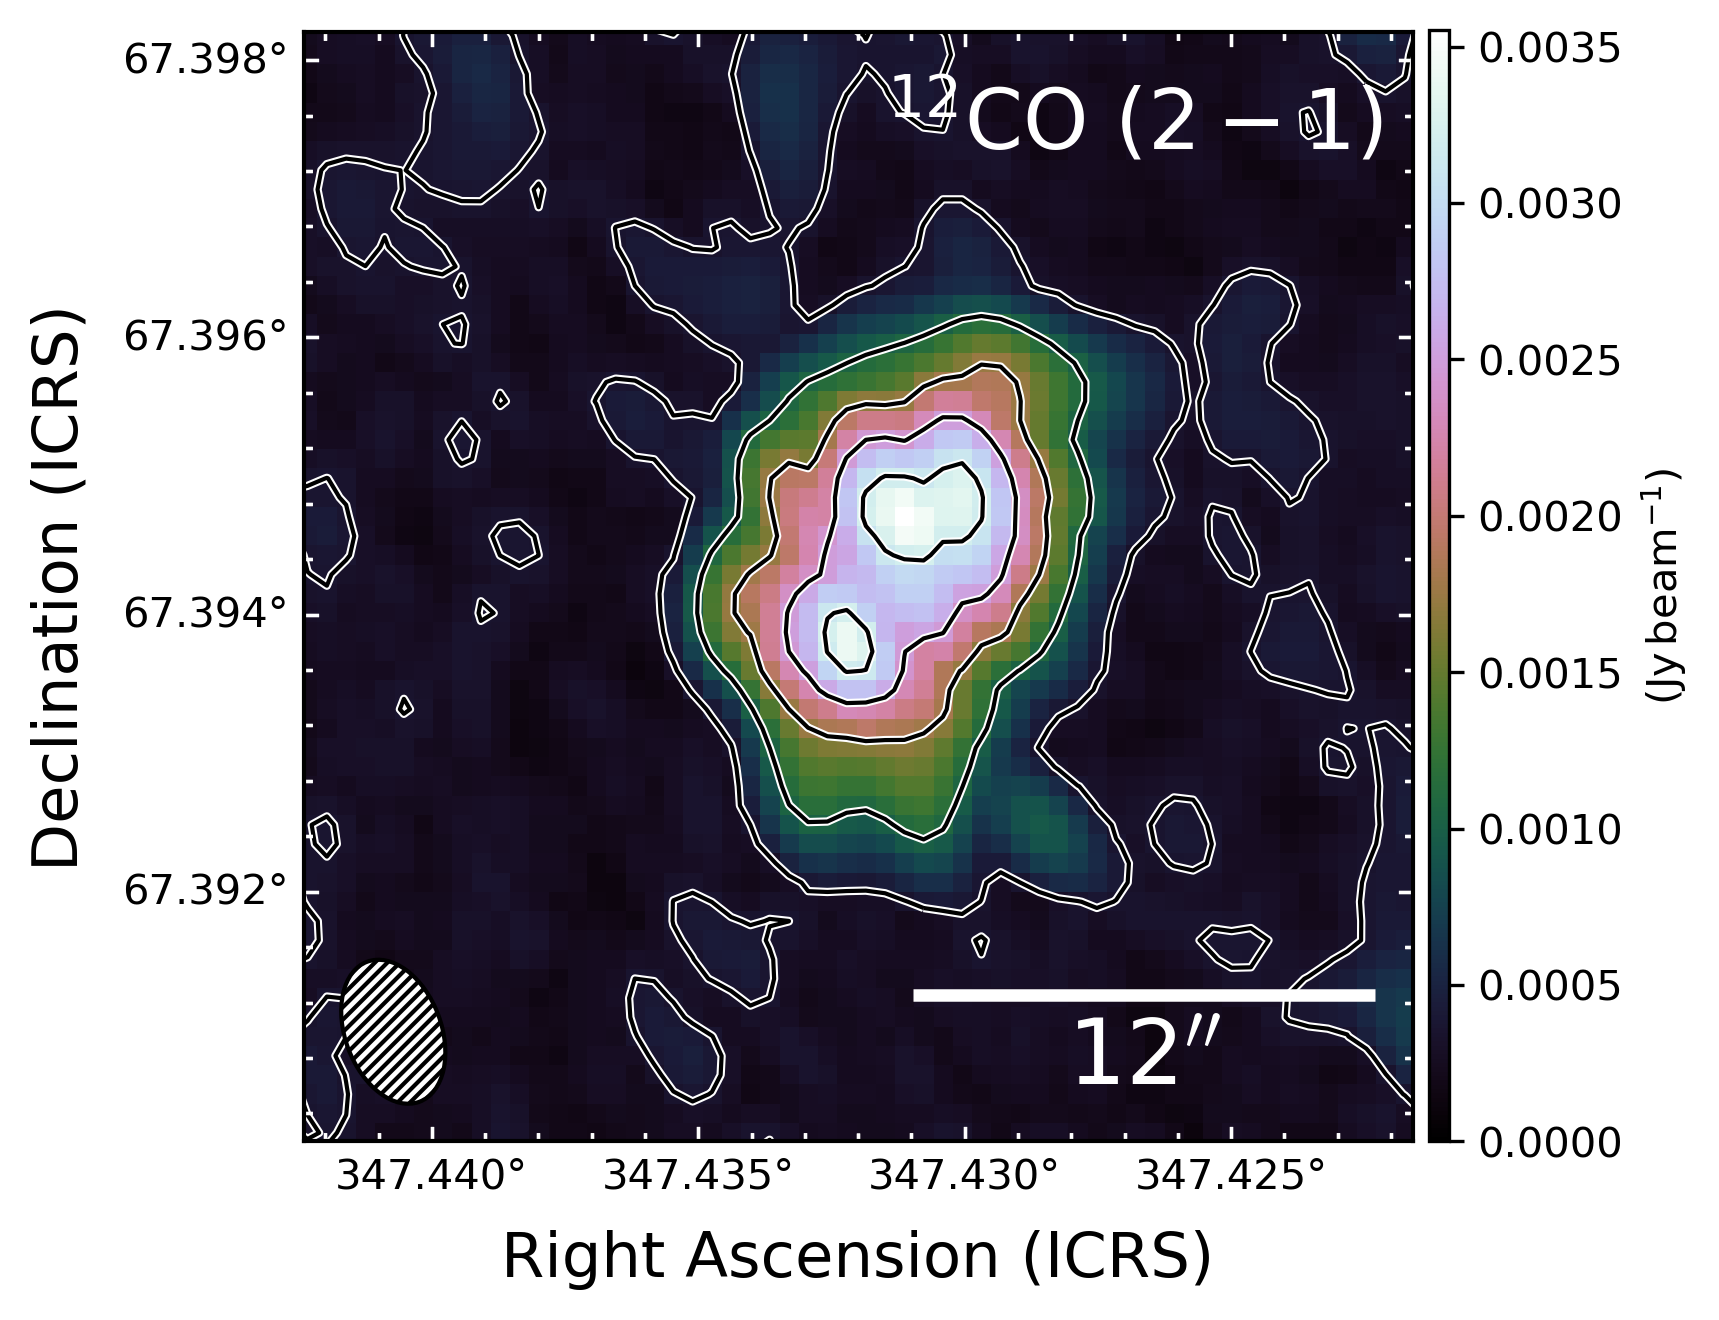

In [65]:
color_table='cubehelix'
fig = plt.figure(dpi=300)

f_max_12CO = aplpy.FITSFigure(max_12CO, figure=fig)#, slices=[0],

vmin, vmax = np.nanpercentile(max_12CO[0].data, [2, 98])
f_max_12CO.show_colorscale(cmap=color_table, vmax=10000) 

max_em_mom8 = 3.5 # mJy/beam m/s from max map
c_levs = np.arange(0.1,1.2,0.2)*max_em_mom8

# adopt the default layout
figure_layout( f_max_12CO, c_unit='(Jy beam$^{-1}$)', colorbar=False, fontcolor='white')

f_max_12CO.show_contour(colors='white', linewidths=2., levels=c_levs)
f_max_12CO.show_contour(colors='black', linewidths=1., levels=c_levs)

# got the coordinates of the center from CASAviewer
f_max_12CO.recenter(347.432,67.3942,width=0.008,height=0.008)

f_max_12CO.add_label(0.75,0.92, '$^{12}$CO $(2-1)$', relative=True, color='white', size=20)


im = plt.imshow(max_12CO[0].data/1000., cmap=color_table)
cb_ax = fig.add_axes([0.81, 0.11, 0.01, 0.772]) #right, top, thickness, length
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('$(\mathrm{Jy\,beam^{-1}})$', fontsize=10)

#fig.savefig('../plots/max_12CO_withcontours_2.pdf', bbox_inches='tight')

INFO: Auto-setting vmin to -1.000e+03 [aplpy.core]


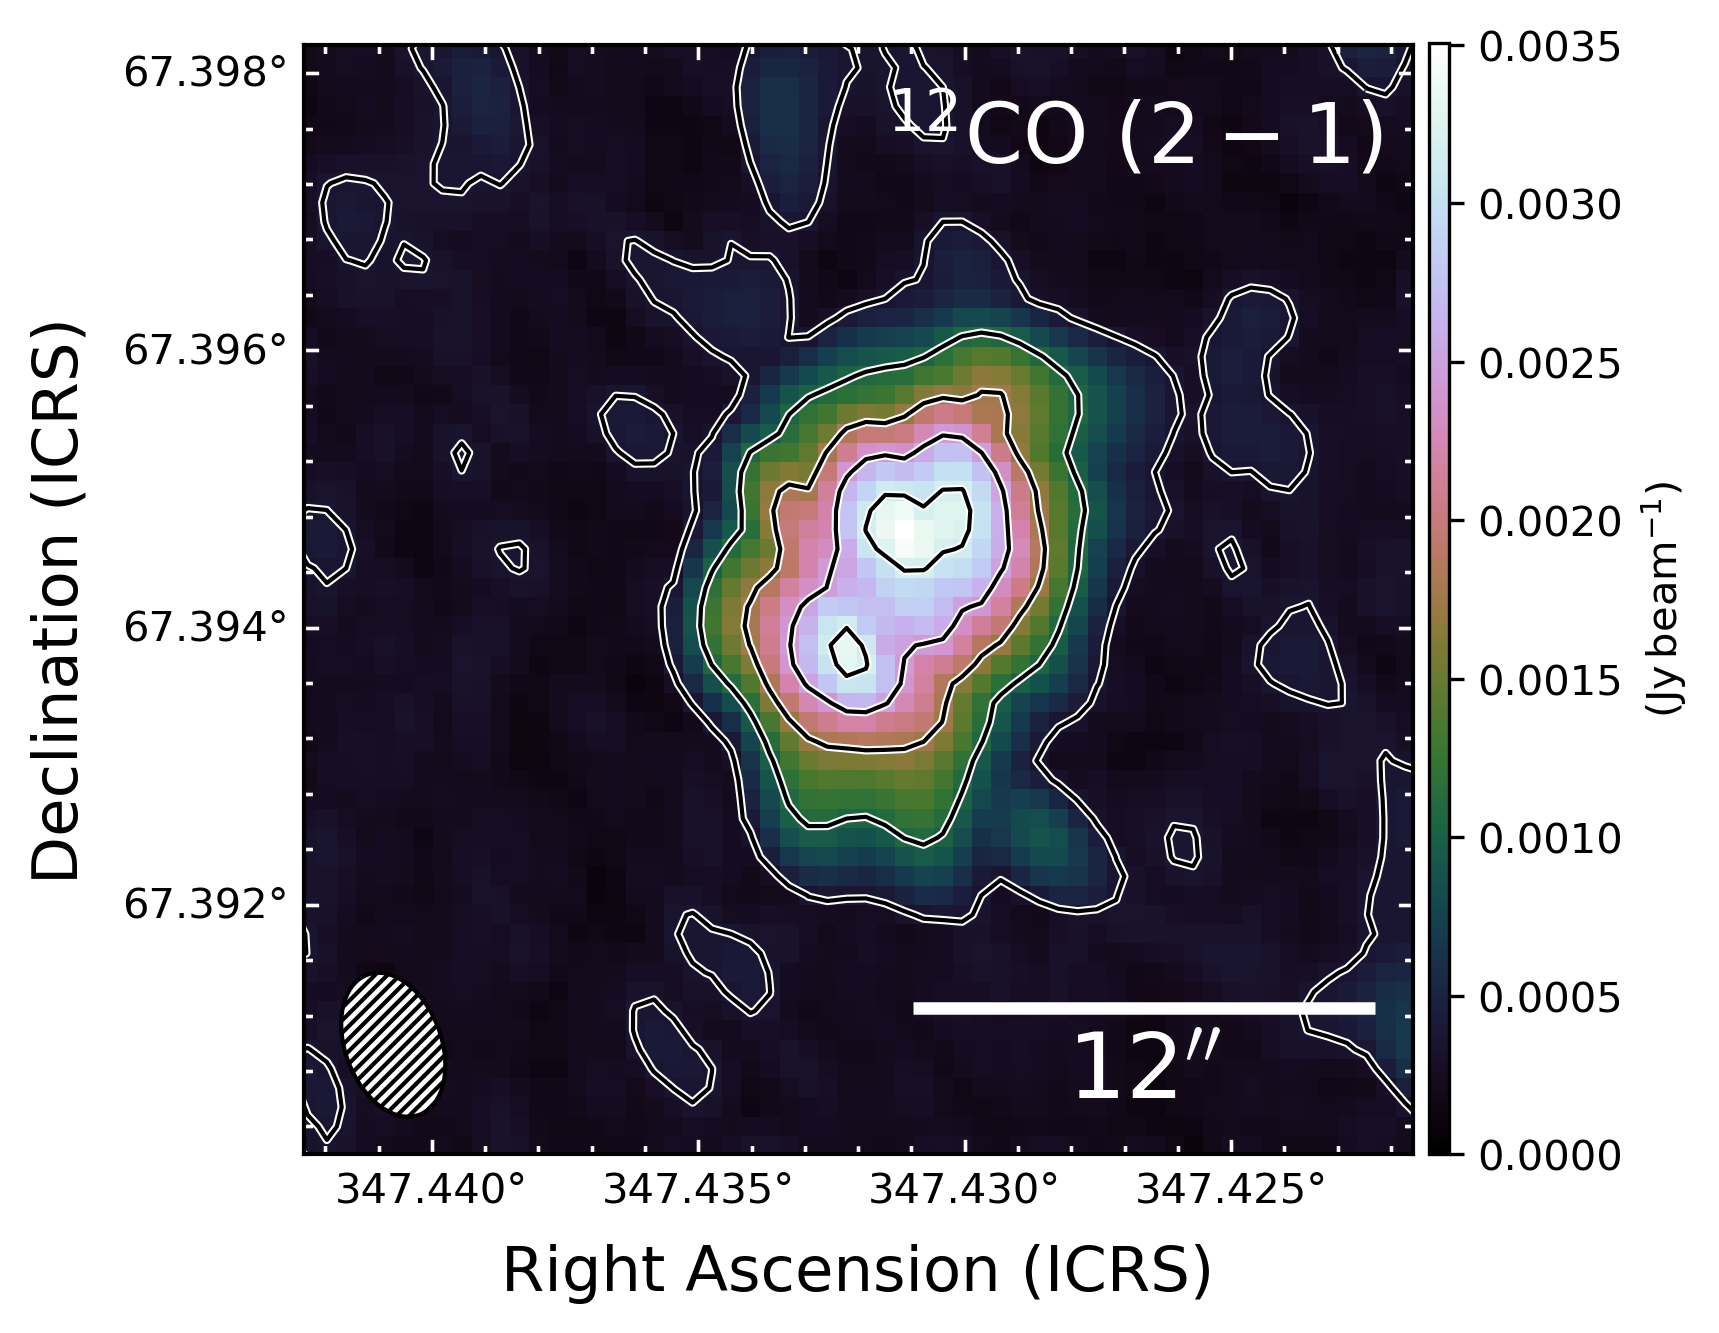

In [66]:
color_table='cubehelix'
fig = plt.figure(dpi=300)

f_mom8_12CO = aplpy.FITSFigure(mom8_12CO, figure=fig)#, slices=[0],

vmin, vmom8 = np.nanpercentile(mom8_12CO[0].data, [2, 98])
f_mom8_12CO.show_colorscale(cmap=color_table, vmax=10000) 

mom8_em = 3.5 # mJy/beam m/s from mom8 map
c_levs = np.arange(0.1,1.2,0.2)*mom8_em

# adopt the default layout
figure_layout( f_mom8_12CO, c_unit='(Jy beam$^{-1}$)', colorbar=False, fontcolor='white')

f_mom8_12CO.show_contour(colors='white', linewidths=2., levels=c_levs)
f_mom8_12CO.show_contour(colors='black', linewidths=1., levels=c_levs)

# got the coordinates of the center from CASAviewer
f_mom8_12CO.recenter(347.432,67.3942,width=0.008,height=0.008)

f_mom8_12CO.add_label(0.75,0.92, '$^{12}$CO $(2-1)$', relative=True, color='white', size=20)


im = plt.imshow(mom8_12CO[0].data/1000., cmap=color_table)
cb_ax = fig.add_axes([0.81, 0.11, 0.01, 0.772]) #right, top, thickness, length
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('$(\mathrm{Jy\,beam^{-1}})$', fontsize=10)

#fig.savefig('../plots/mom8_12CO_withcontours_2.pdf', bbox_inches='tight')

INFO: Auto-setting vmin to -1.000e+03 [aplpy.core]


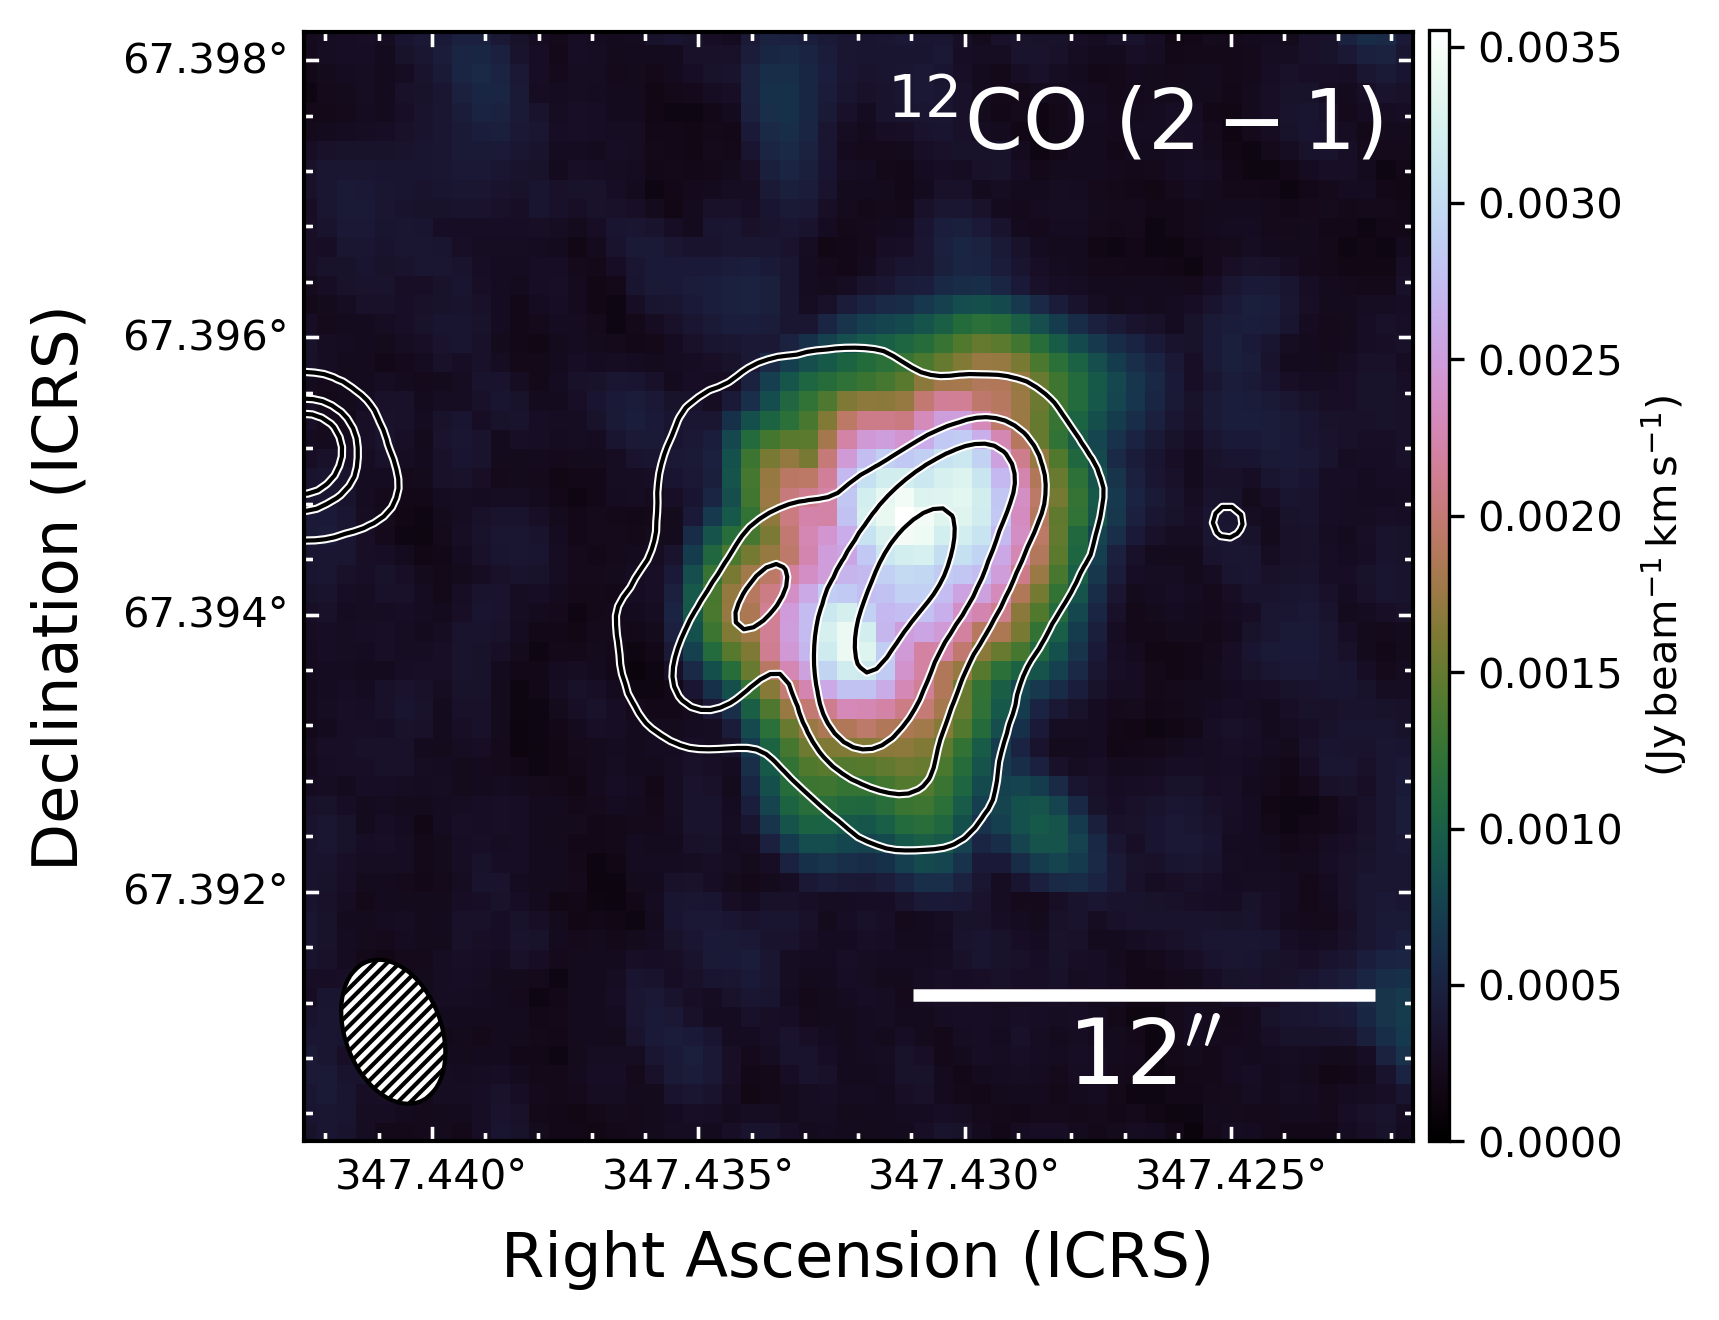

In [67]:
color_table='cubehelix'
fig = plt.figure(dpi=300)

f_max_12CO = aplpy.FITSFigure(max_12CO, figure=fig)#, slices=[0],

vmin, vmax = np.nanpercentile(max_12CO[0].data, [2, 98])
f_max_12CO.show_colorscale(cmap=color_table, vmax=10000) 


# adopt the default layout
figure_layout( f_max_12CO, c_unit='(Jy beam$^{-1}$ m s$^{-1}$)', colorbar=False, fontcolor='white')

rms_PS1 = 17.
c_levs = np.array([4, 16, 40, 160, 400, 1600])*rms
f_max_12CO.show_contour('/Users/kristina/Hamburgers/Draculas_Chivito/Pan-STARRS_fits_files/cutout_rings.v3.skycell.2537.088.stk.g.unconv.fits', colors='white', linewidths=2., levels=c_levs, smooth=3, kernel='box')
f_max_12CO.show_contour('/Users/kristina/Hamburgers/Draculas_Chivito/Pan-STARRS_fits_files/cutout_rings.v3.skycell.2537.088.stk.g.unconv.fits', colors='black', linewidths=1., levels=c_levs, smooth=3, kernel='box')

# got the coordinates of the center from CASAviewer
f_max_12CO.recenter(347.432,67.3942,width=0.008,height=0.008)

f_max_12CO.add_label(0.75,0.92, '$^{12}$CO $(2-1)$', relative=True, color='white', size=20)


im = plt.imshow(max_12CO[0].data/1000., cmap=color_table)
cb_ax = fig.add_axes([0.81, 0.11, 0.01, 0.772]) #right, top, thickness, length
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('$(\mathrm{Jy\,beam^{-1}\,km\,s^{-1}})$', fontsize=10)

#fig.savefig('../plots/max_12CO_withcontours_2.pdf', bbox_inches='tight')

## See Eq. 4 in Friesen+2009: https://iopscience.iop.org/article/10.1088/0004-637X/697/2/1457/pdf

In [69]:
## Plot 2nd moment map using "effective width" method in bettermoments

!bettermoments /Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/DraChi.briggs0.12CO.LSRK.im.image.fits -clip 5 -method width


Loading up data...
Estimating noise in the data...
Estimated RMS: 9.93e-02.
Calculating threshold-based mask...
Masking the data...
Calculating maps...
Checking for NaNs in error maps.
Saving moment maps...


In [70]:
mom2_12CO = fits.open('/Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/DraChi.briggs0.12CO.LSRK.im.image_dV.fits')

mom2_12CO[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  144                                                  
NAXIS2  =                  144                                                  
BMAJ    = 0.001078328424029880                                                  
BMIN    = 0.000693414211273193                                                  
BPA     =            20.496504                                                  
BUNIT   = 'm/s     '                                                            
CTYPE1  = 'RA---SIN'                                                            
CRVAL1  =       347.4318541667                                                  
CDELT1  =  -0.0001388888888889                                                  
CRPIX1  =                 73

invalid value encountered in subtract


INFO: Auto-setting vmin to -7.955e+02 [aplpy.core]


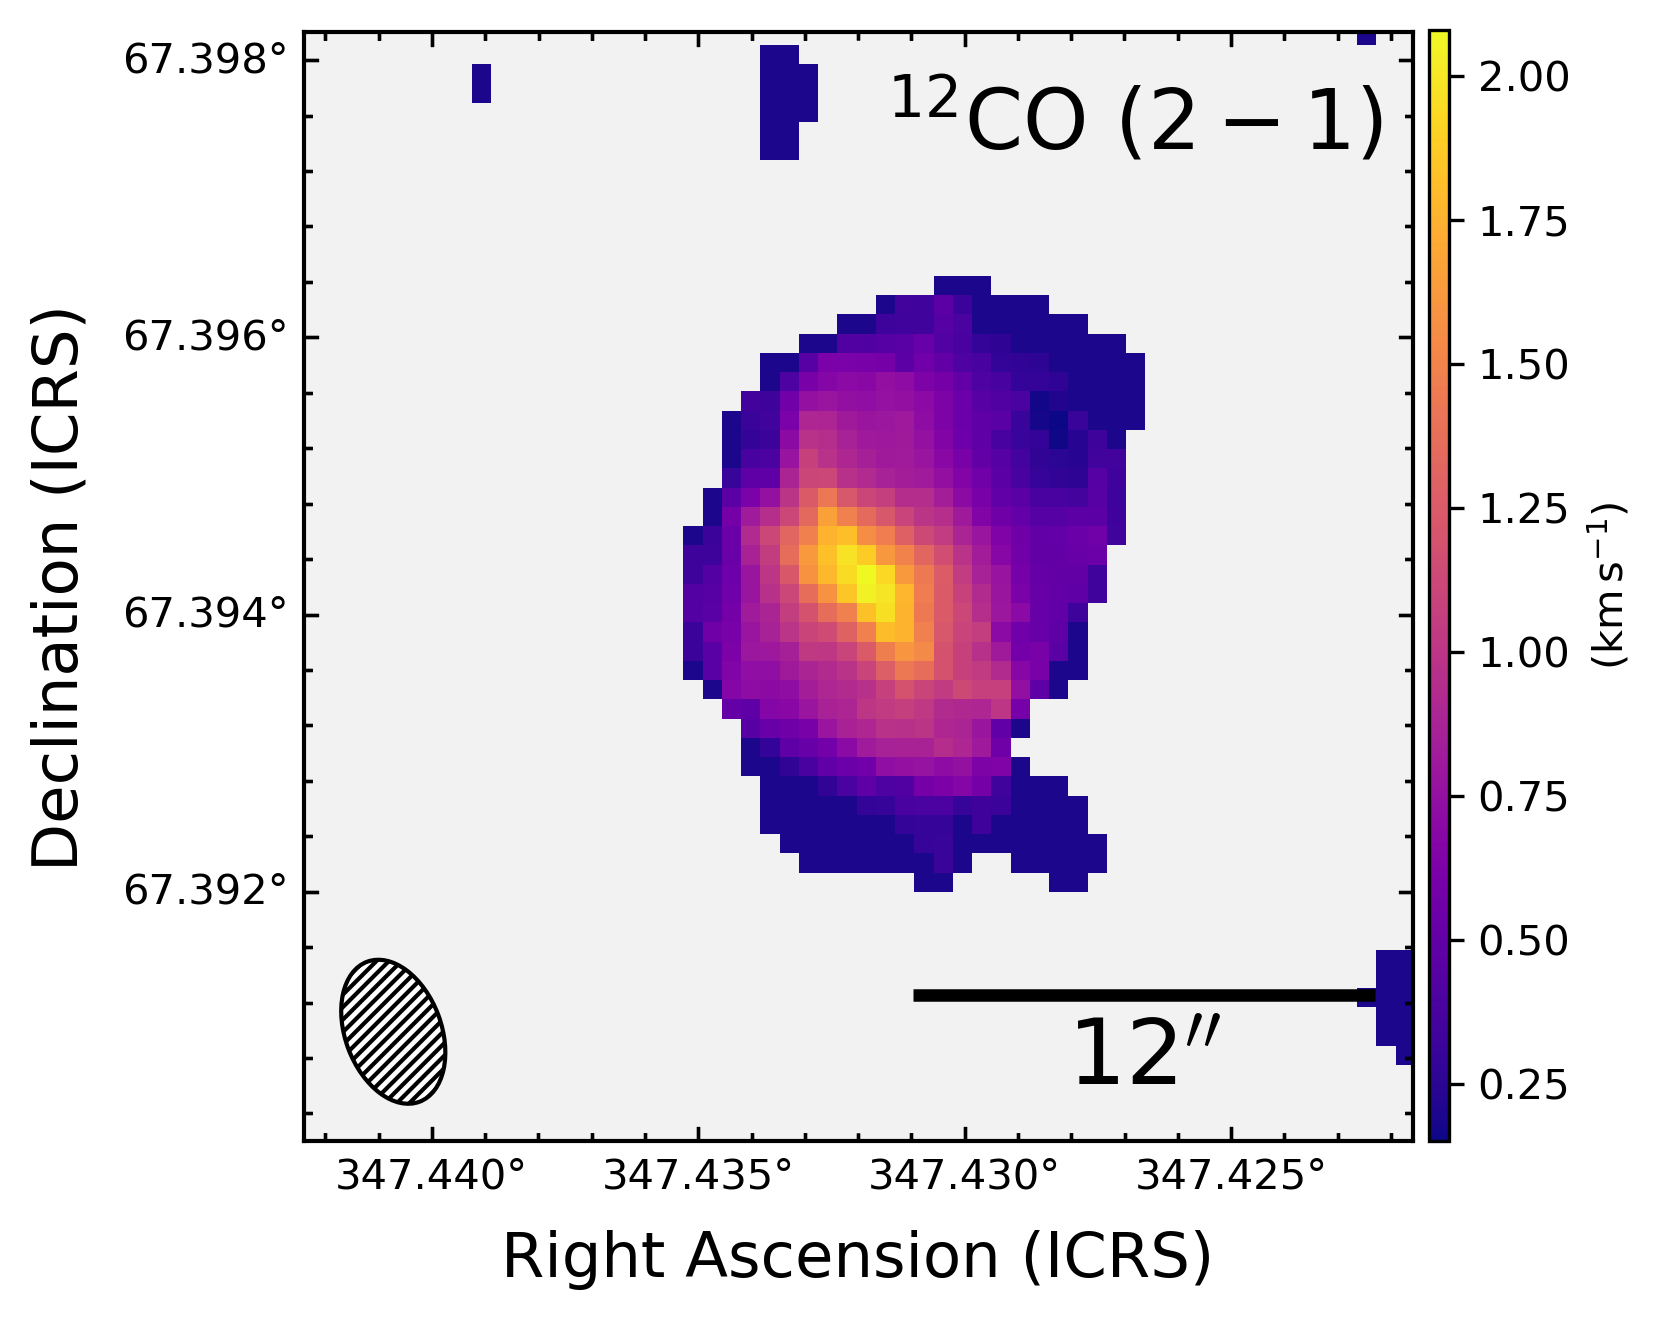

In [71]:
color_table='plasma'
fig = plt.figure(dpi=300)

f_mom2_12CO = aplpy.FITSFigure(mom2_12CO, figure=fig)#, slices=[0],

vmin, vmax = np.nanpercentile(mom2_12CO[0].data, [2, 98])
f_mom2_12CO.show_colorscale(cmap=color_table, vmax=10000) 

# adopt the default layout
figure_layout( f_mom2_12CO, c_unit='(m/s)', fontcolor='black', colorbar=False)

# got the coordinates of the center from CASAviewer
f_mom2_12CO.recenter(347.432,67.3942,width=0.008,height=0.008)

f_mom2_12CO.add_label(0.75,0.92, '$^{12}$CO $(2-1)$', relative=True, color='black', size=20)


im = plt.imshow(mom2_12CO[0].data/1000., cmap=color_table)
cb_ax = fig.add_axes([0.81, 0.11, 0.01, 0.772]) #right, top, thickness, length
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_label('$(\mathrm{km\,s^{-1}})$', fontsize=10)

#fig.savefig('../plots/mom2_12CO_withcontours.pdf', bbox_inches='tight')

In [72]:
channel_width = -cube_contour.header['CDELT3']*1000.
print(channel_width, 'm/s')

363.19867730252 m/s


In [73]:
(channel_width/(2.*np.sqrt(2*np.log(2))))**2

23788.82921512725

In [76]:
flags = (mom2_12CO[0].data > 0.) & (mom2_12CO[0].data != np.inf) & (mom2_12CO[0].data > 2.*np.nanmin(mom2_12CO[0].data))

dv = mom2_12CO[0].data[flags]
dv = np.array(dv)
print(np.min(dv))

301.4734061713268


In [78]:
np.sqrt((dv)**2. - (channel_width/(2.*np.sqrt(2*np.log(2))))**2)

array([ 304.22936832,  292.96447061,  308.89034371,  282.72691724,
        293.60556935,  273.46088317,  263.0620072 ,  295.90381378,
        347.89536277,  357.83854012,  364.96983805,  297.01868613,
        280.80726303,  353.22347086,  462.64419597,  378.11244621,
        388.13059628,  574.50732726,  611.61806498,  659.75125298,
        573.20315449,  302.08115749,  312.12291105,  312.29340982,
        344.17754909,  469.72821343,  522.77449752,  557.33384971,
        717.24589153,  735.68397053,  750.86064811,  700.84887925,
        730.37985538,  620.81041659,  623.87285065,  314.24448821,
        314.47253974,  461.79855048,  507.05170101,  562.7436677 ,
        685.3713074 ,  810.72146926,  848.75350107,  859.59145458,
        855.95419487,  929.68418524,  883.49758834,  796.23575513,
        536.06372452,  420.64506869,  510.46609116,  540.21854789,
        584.42947439,  768.11181942,  855.57360095,  884.82238478,
        961.16437041,  958.52967872,  986.15085786,  883.66486

Text(0.5, 0, 'Mach Number')

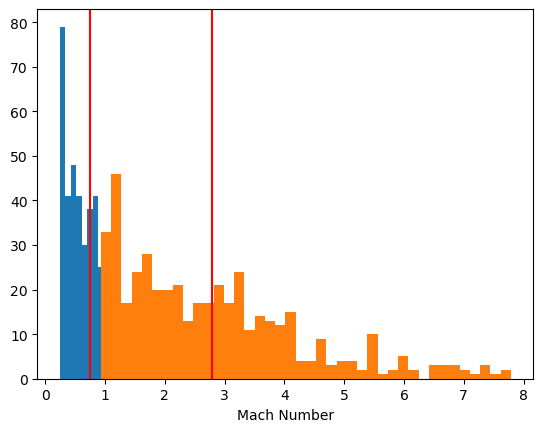

In [81]:
import astropy.constants as const
#const.k_B.cgs

def sound_speed(mu=2.33, T=20.*u.K):
    return np.sqrt(const.k_B.cgs*T/mu/const.m_p.cgs).to(u.km/u.s)


dv_thermal = sound_speed(28.0101, T=20.*u.K)
c_s = sound_speed(2.33, T=20*u.K)


dv_nonthermal = np.sqrt(dv_corrected**2.-dv_thermal.value**2.)
dv_nonthermal

plt.hist(dv_nonthermal, bins=20)
plt.axvline(np.mean(dv_nonthermal), color='red')


plt.hist(dv_nonthermal/c_s.value, bins=40)

plt.axvline(np.mean(dv_nonthermal/c_s.value), color='red')
plt.xlabel('Mach Number')

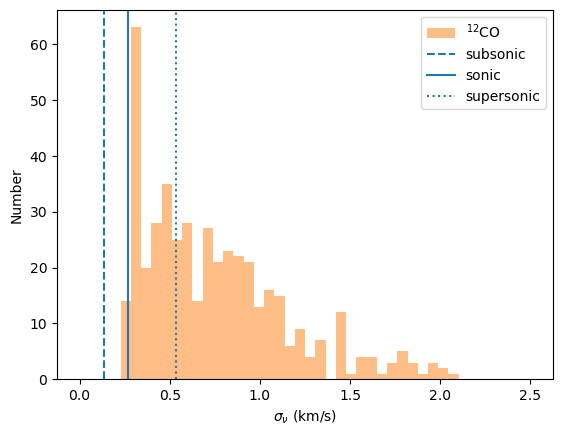

In [82]:
#bins = np.logspace(-2,1,30)
bins = np.linspace(0,2.5,45)
#plt.hist(dv/1000, bins=bins, color='C0')

plt.hist(dv_corrected, bins=bins, color='C1', alpha=0.5, label='$^{12}$CO')

plt.axvline(0.5*c_s.value, ls='--', label='subsonic')
plt.axvline(1.0*c_s.value, ls='-', label='sonic')
plt.axvline(2*c_s.value, ls=':', label='supersonic')

plt.xlabel('$\\sigma_\\nu$ (km/s)')
plt.ylabel('Number')
plt.legend()

#plt.xscale('log')

## Measure "FWHM" of 12CO emission to extract the size

(144, 144)


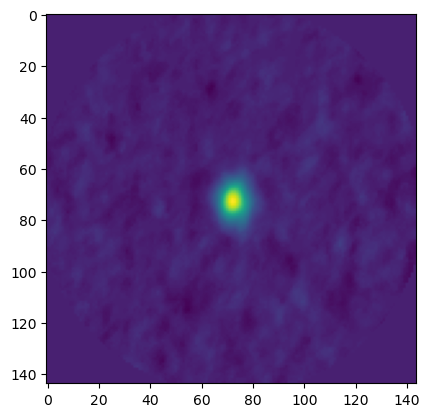

In [11]:
plt.imshow(mom0_12CO[0].data)
print(mom0_12CO[0].shape)

In [13]:
#splits the array into 391 subarrays (i.e. one subarray per y-pixel)
np.array_split(mom0_12CO[0].data, mom0_12CO[0].shape[0], axis=0)[0].shape

(1, 144)

In [62]:
#left and right limit of the cube in units of radians
# got these value from CASA by reading off the values of a box that's covering the entire mom0 map with radius=8.5711e-05
xcen = 6.06383

xmin = xcen-5.8062e-05
xmax = xcen+5.8062e-05

# sequence along each horizontal cut
xseq = np.linspace(xmin, xmax, num = 144)
vec_max_values = [xseq[np.max(el) == el][0] for el in mom0_12CO[0].data] #determine the xition in xseq where the element in f1 is maximal

In [63]:
# center all lines to their maximum and "stack" them onto one xition
from scipy.interpolate import InterpolatedUnivariateSpline as spl

delta_xgrid = xmax - xmin
new_grid = np.linspace(-delta_xgrid, delta_xgrid, num = 144)
list_centered = []
for i in range(len(mom0_12CO[0].data)):
    new_xvec = xseq - vec_max_values[i]
    model = spl(new_xvec, mom0_12CO[0].data[i], ext=1)
    list_centered.append(model(new_grid))

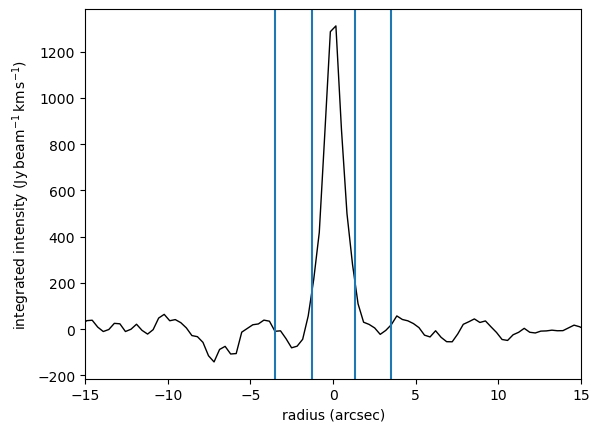

In [99]:
list_centered = np.array(list_centered)

dist = 380.*u.pc
new_grid_converted=(new_grid*u.rad).to(u.arcsec)*dist #conversion from rad into arcsec into parsec
new_grid_arcsec = (new_grid*u.rad).to(u.arcsec)#*206265. #conversion from rad into arcsec
normed_intensity = np.sum(list_centered, axis=0)/(np.max(np.sum(list_centered, axis=0))) 

plt.plot(new_grid_arcsec, np.mean(list_centered, axis=0), lw=1., color='black', label='mean filament profile')
plt.xlabel('radius (arcsec)')
plt.ylabel('integrated intensity $(\mathrm{Jy\,beam^{-1}\,km\,s^{-1}})$')
plt.xlim(-15,15)
plt.axvline(1.3)
plt.axvline(-1.3)

plt.axvline(3.5)
plt.axvline(-3.5)


In [91]:
mean_list_centered = np.mean(list_centered, axis=0)
median_list_centered = np.median(list_centered, axis=0)
std_list_centered = np.std(list_centered, axis=0)

#### Fit Gaussian to the data

In [92]:
from scipy.interpolate import InterpolatedUnivariateSpline

def get_fwhm(grid, values): 
    model = InterpolatedUnivariateSpline(grid, values - np.max(values)/2.0)
    return model.roots()[-1] - model.roots()[0]

In [93]:
fwhm = get_fwhm(new_grid_arcsec, np.mean(list_centered, axis=0))
sigma = fwhm/(2.*np.sqrt(2*np.log(2.)))

print('FWHM = ', fwhm)
print('sigma = ', sigma)

FWHM =  1.3068232472217374
sigma =  0.5549567364943004


In [84]:
from radio_beam import Beam

imgscale_ang = (abs(mom0_12CO[0].header["CDELT1"])*u.deg).to(u.arcsec) # degrees
beam = Beam(major=mom0_12CO[0].header["BMAJ"]*u.deg, minor=mom0_12CO[0].header["BMIN"]*u.deg, pa=mom0_12CO[0].header["BPA"]*u.deg)
imgscale = (abs(mom0_12CO[0].header["CDELT1"])*u.deg).to(u.arcsec) * (np.pi / 180.0) * distance

print(beam)
print(imgscale_ang, imgscale)

Beam: BMAJ=3.881982326507568 arcsec BMIN=2.4962911605834948 arcsec BPA=20.496504 deg
0.50000000000004 arcsec 3.316125578789491 arcsec pc


In [94]:
fwhm

1.3068232472217374

In [95]:
beamwidth_phys = ((mom0_12CO[0].header["BMAJ"]*u.deg).to(u.arcsec)/imgscale_ang).decompose()*imgscale.value
beamwidth_phys

<Quantity 25.74628178>

In [96]:
FWHM_deconv = np.sqrt(fwhm**2.-beamwidth_phys**2.)
FWHM_deconv

<Quantity nan>

In [89]:
beamwidth_phys

<Quantity 25.74628178>

In [35]:
beamwidth_phys = (beam/imgscale_ang).decompose()*imgscale.value

AttributeError: 'Quantity' object has no 'to_header_keywords' member

In [ ]:
FWHM_deconv = np.sqrt(fwhm**2.-beamwidth_phys**2.)

In [14]:
mom0_12CO[0].shape[0]

144